In [2]:
#import io
#from io import BytesIO
#from IPython.display import SVG, Image as display_Image
from helper import *
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
#from openeye import oechem, oemolprop
import pandas as pd
import pickle
#from PIL import Image as pilImage
#from rdkit import Chem
#from rdkit.Chem.Draw import rdMolDraw2D



#from rdkit import Chem, SimDivFilters, DataStructs
#from rdkit.Chem import AllChem, Descriptors
#from scipy import stats
#from scipy.spatial.distance import euclidean, cityblock
#import seaborn as sns

%matplotlib inline

In [3]:
pamine_df = pd.read_csv('../../files/pamine_df.csv')
pAA_df = pd.read_csv('../../files/pAA_df.csv')
cooh_df = pd.read_csv('../../files/cooh_df.csv')

umap_coordinates = pd.read_csv('../../files/truncates_UMAP.csv')

In [4]:
pamine_umap = pamine_df.merge(umap_coordinates, on='truncate_SMILES')
pAA_umap = pAA_df.merge(umap_coordinates, on='truncate_SMILES')
cooh_umap = cooh_df.merge(umap_coordinates, on='truncate_SMILES')

In [5]:
pamine_umap['mol'] = pamine_umap['BB_SMILES'].apply(Chem.MolFromSmiles)
cooh_umap['mol'] = cooh_umap['BB_SMILES'].apply(Chem.MolFromSmiles)

pamine_umap['MW'] = pamine_umap['mol'].apply(Descriptors.MolWt)
cooh_umap['MW'] = cooh_umap['mol'].apply(Descriptors.MolWt)

pamine_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in pamine_umap['mol']]
cooh_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in cooh_umap['mol']]

pamine_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in pamine_umap['mol']]
cooh_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in cooh_umap['mol']]

### Figure 2: Comparison of $1^{o}$ amino and $1^{o}$ amine building blocks

In [6]:
z_pamine = kde_(pamine_umap)
z_pAA = kde_(pAA_umap)
z_cooh = kde_(cooh_umap)

In [7]:
xlim = [-5.5, 20.5]
ylim = [-8, 11]

In [8]:
### Convert densities to the same range

t_min = np.min([np.min(z_pamine), np.min(z_pAA), np.min(z_cooh)])
t_max = np.max([np.max(z_pamine), np.max(z_pAA), np.max(z_cooh)])

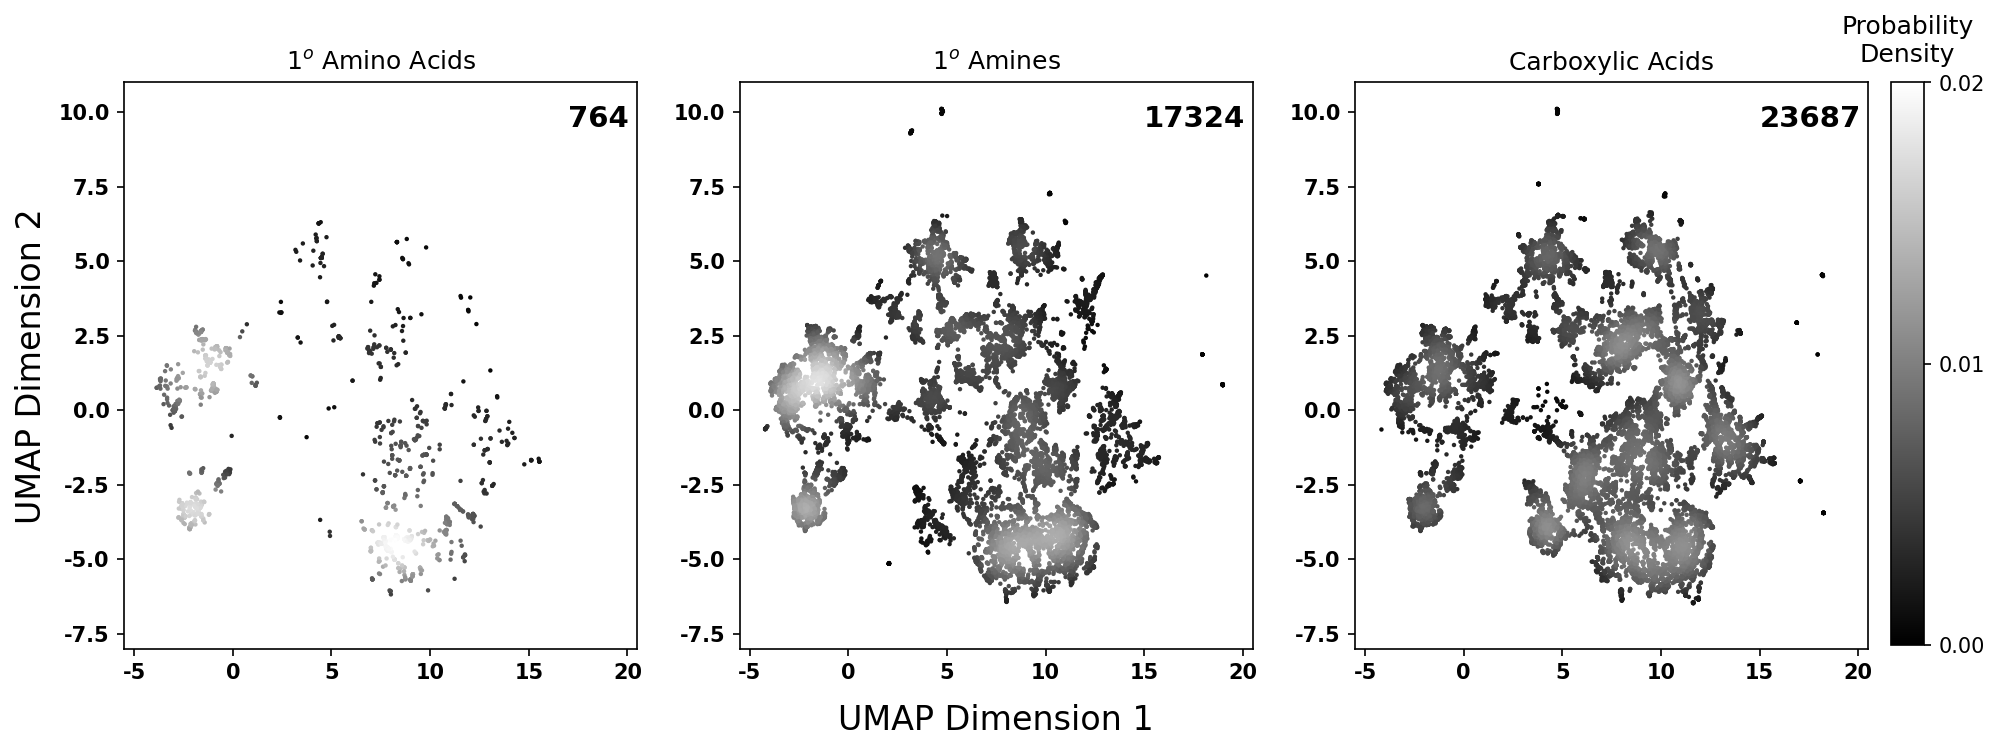

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=150)
for ax in axs.reshape(-1):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

cmap_color='gray'

sc = axs[0].scatter(pAA_umap['X'], pAA_umap['Y'], c=z_pAA, s=5, cmap=cmap_color, marker='.',
                   vmin=t_min, vmax=t_max)
axs[1].scatter(pamine_umap['X'], pamine_umap['Y'], c=z_pamine, s=5, cmap=cmap_color, marker='.',
               vmin=t_min, vmax=t_max)
axs[2].scatter(cooh_umap['X'], cooh_umap['Y'], c=z_cooh, s=5, cmap=cmap_color, marker='.',
               vmin=t_min, vmax=t_max)

axs[0].text(17, 9.5, f"{len(set(pAA_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[1].text(15, 9.5, f"{len(set(pamine_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[2].text(15, 9.5, f"{len(set(cooh_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')

axs[1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16, rotation=0)
axs[0].set_ylabel('UMAP Dimension 2', labelpad=5, fontsize=16)

axs[0].set_xticks(np.arange(-5, 25, 5))
axs[0].set_xticklabels(np.arange(-5, 25, 5), fontweight='bold')

axs[0].set_yticks(np.arange(-7.5, 12.5, 2.5))
axs[0].set_yticklabels(np.arange(-7.5, 12.5, 2.5), fontweight='bold')

axs[1].set_xticks(np.arange(-5, 25, 5))
axs[1].set_xticklabels(np.arange(-5, 25, 5), fontweight='bold')

axs[1].set_yticks(np.arange(-7.5, 12.5, 2.5))
axs[1].set_yticklabels(np.arange(-7.5, 12.5, 2.5), fontweight='bold')

axs[2].set_xticks(np.arange(-5, 25, 5))
axs[2].set_xticklabels(np.arange(-5, 25, 5), fontweight='bold')

axs[2].set_yticks(np.arange(-7.5, 12.5, 2.5))
axs[2].set_yticklabels(np.arange(-7.5, 12.5, 2.5), fontweight='bold')

axs[0].set_title("$1^o$ Amino Acids")
axs[1].set_title("$1^o$ Amines")
axs[2].set_title("Carboxylic Acids")

n_ticks = 3
cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
cbar_ax.set_title("Probability\nDensity", pad=10)

cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_ticks(np.linspace(t_min, t_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(t_min, t_max, n_ticks)])

plt.show()

### Figure 2: Sample Compounds in Specified Region

In [10]:
c1_xmin, c1_xmax, c1_ymin, c1_ymax = -3, -1.2, -5, -2.6
pAA_cluster_1 = pAA_umap.loc[(pAA_umap['X']>c1_xmin)&(pAA_umap['X']<c1_xmax)
                           &(pAA_umap['Y']>c1_ymin)&(pAA_umap['Y']<c1_ymax)]

c2_xmin, c2_xmax, c2_ymin, c2_ymax = -2.5, -0.8, 0.4, 2
pAA_cluster_2 = pAA_umap.loc[(pAA_umap['X']>c2_xmin)&(pAA_umap['X']<c2_xmax)
                           &(pAA_umap['Y']>c2_ymin)&(pAA_umap['Y']<c2_ymax)]

c3_xmin, c3_xmax, c3_ymin, c3_ymax = 3.6, 5.5, 4.5, 6
pAA_cluster_3 = pAA_umap.loc[(pAA_umap['X']>c3_xmin)&(pAA_umap['X']<c3_xmax)
                           &(pAA_umap['Y']>c3_ymin)&(pAA_umap['Y']<c3_ymax)]

c4_xmin, c4_xmax, c4_ymin, c4_ymax = 3.4, 5.2, -0.5, 1
pAA_cluster_4 = pAA_umap.loc[(pAA_umap['X']>c4_xmin)&(pAA_umap['X']<c4_xmax)
                           &(pAA_umap['Y']>c4_ymin)&(pAA_umap['Y']<c4_ymax)]

c5_xmin, c5_xmax, c5_ymin, c5_ymax = 3.2, 5.1, -5, -2.5
pAA_cluster_5 = pAA_umap.loc[(pAA_umap['X']>c5_xmin)&(pAA_umap['X']<c5_xmax)
                           &(pAA_umap['Y']>c5_ymin)&(pAA_umap['Y']<c5_ymax)]

c6_xmin, c6_xmax, c6_ymin, c6_ymax = 7, 8.8, -5.3, -3.6
pAA_cluster_6 = pAA_umap.loc[(pAA_umap['X']>c6_xmin)&(pAA_umap['X']<c6_xmax)
                           &(pAA_umap['Y']>c6_ymin)&(pAA_umap['Y']<c6_ymax)]

c7_xmin, c7_xmax, c7_ymin, c7_ymax = 10.2, 12.1, -0.5, 1.5
pAA_cluster_7 = pAA_umap.loc[(pAA_umap['X']>c7_xmin)&(pAA_umap['X']<c7_xmax)
                           &(pAA_umap['Y']>c7_ymin)&(pAA_umap['Y']<c7_ymax)]

c8_xmin, c8_xmax, c8_ymin, c8_ymax = 12.5, 15, -2, 0
pAA_cluster_8 = pAA_umap.loc[(pAA_umap['X']>c8_xmin)&(pAA_umap['X']<c8_xmax)
                           &(pAA_umap['Y']>c8_ymin)&(pAA_umap['Y']<c8_ymax)]

In [11]:
c1_xmin, c1_xmax, c1_ymin, c1_ymax = -3, -1.2, -5, -2.6
pamine_cluster_1 = pamine_umap.loc[(pamine_umap['X']>c1_xmin)&(pamine_umap['X']<c1_xmax)
                           &(pamine_umap['Y']>c1_ymin)&(pamine_umap['Y']<c1_ymax)]

c2_xmin, c2_xmax, c2_ymin, c2_ymax = -2.5, -0.8, 0.4, 2
pamine_cluster_2 = pamine_umap.loc[(pamine_umap['X']>c2_xmin)&(pamine_umap['X']<c2_xmax)
                           &(pamine_umap['Y']>c2_ymin)&(pamine_umap['Y']<c2_ymax)]

c3_xmin, c3_xmax, c3_ymin, c3_ymax = 3.6, 5.5, 4.5, 6
pamine_cluster_3 = pamine_umap.loc[(pamine_umap['X']>c3_xmin)&(pamine_umap['X']<c3_xmax)
                           &(pamine_umap['Y']>c3_ymin)&(pamine_umap['Y']<c3_ymax)]

c4_xmin, c4_xmax, c4_ymin, c4_ymax = 3.4, 5.2, -0.5, 1
pamine_cluster_4 = pamine_umap.loc[(pamine_umap['X']>c4_xmin)&(pamine_umap['X']<c4_xmax)
                           &(pamine_umap['Y']>c4_ymin)&(pamine_umap['Y']<c4_ymax)]

c5_xmin, c5_xmax, c5_ymin, c5_ymax = 3.2, 5.1, -5, -2.5
pamine_cluster_5 = pamine_umap.loc[(pamine_umap['X']>c5_xmin)&(pamine_umap['X']<c5_xmax)
                           &(pamine_umap['Y']>c5_ymin)&(pamine_umap['Y']<c5_ymax)]

c6_xmin, c6_xmax, c6_ymin, c6_ymax = 7, 8.8, -5.3, -3.6
pamine_cluster_6 = pamine_umap.loc[(pamine_umap['X']>c6_xmin)&(pamine_umap['X']<c6_xmax)
                           &(pamine_umap['Y']>c6_ymin)&(pamine_umap['Y']<c6_ymax)]

c7_xmin, c7_xmax, c7_ymin, c7_ymax = 10.2, 12.1, -0.5, 1.5
pamine_cluster_7 = pamine_umap.loc[(pamine_umap['X']>c7_xmin)&(pamine_umap['X']<c7_xmax)
                           &(pamine_umap['Y']>c7_ymin)&(pamine_umap['Y']<c7_ymax)]

c8_xmin, c8_xmax, c8_ymin, c8_ymax = 12.5, 15, -2, 0
pamine_cluster_8 = pamine_umap.loc[(pamine_umap['X']>c8_xmin)&(pamine_umap['X']<c8_xmax)
                           &(pamine_umap['Y']>c8_ymin)&(pamine_umap['Y']<c8_ymax)]

In [12]:
c1_xmin, c1_xmax, c1_ymin, c1_ymax = -3, -1.2, -5, -2.6
cooh_cluster_1 = cooh_umap.loc[(cooh_umap['X']>c1_xmin)&(cooh_umap['X']<c1_xmax)
                           &(cooh_umap['Y']>c1_ymin)&(cooh_umap['Y']<c1_ymax)]

c2_xmin, c2_xmax, c2_ymin, c2_ymax = -2.5, -0.8, 0.4, 2
cooh_cluster_2 = cooh_umap.loc[(cooh_umap['X']>c2_xmin)&(cooh_umap['X']<c2_xmax)
                           &(cooh_umap['Y']>c2_ymin)&(cooh_umap['Y']<c2_ymax)]

c3_xmin, c3_xmax, c3_ymin, c3_ymax = 3.6, 5.5, 4.5, 6
cooh_cluster_3 = cooh_umap.loc[(cooh_umap['X']>c3_xmin)&(cooh_umap['X']<c3_xmax)
                           &(cooh_umap['Y']>c3_ymin)&(cooh_umap['Y']<c3_ymax)]

c4_xmin, c4_xmax, c4_ymin, c4_ymax = 3.4, 5.2, -0.5, 1
cooh_cluster_4 = cooh_umap.loc[(cooh_umap['X']>c4_xmin)&(cooh_umap['X']<c4_xmax)
                           &(cooh_umap['Y']>c4_ymin)&(cooh_umap['Y']<c4_ymax)]

c5_xmin, c5_xmax, c5_ymin, c5_ymax = 3.2, 5.1, -5, -2.5
cooh_cluster_5 = cooh_umap.loc[(cooh_umap['X']>c5_xmin)&(cooh_umap['X']<c5_xmax)
                           &(cooh_umap['Y']>c5_ymin)&(cooh_umap['Y']<c5_ymax)]

c6_xmin, c6_xmax, c6_ymin, c6_ymax = 7, 8.8, -5.3, -3.6
cooh_cluster_6 = cooh_umap.loc[(cooh_umap['X']>c6_xmin)&(cooh_umap['X']<c6_xmax)
                           &(cooh_umap['Y']>c6_ymin)&(cooh_umap['Y']<c6_ymax)]

c7_xmin, c7_xmax, c7_ymin, c7_ymax = 10.2, 12.1, -0.5, 1.5
cooh_cluster_7 = cooh_umap.loc[(cooh_umap['X']>c7_xmin)&(cooh_umap['X']<c7_xmax)
                           &(cooh_umap['Y']>c7_ymin)&(cooh_umap['Y']<c7_ymax)]

c8_xmin, c8_xmax, c8_ymin, c8_ymax = 12.5, 15, -2, 0
cooh_cluster_8 = cooh_umap.loc[(cooh_umap['X']>c8_xmin)&(cooh_umap['X']<c8_xmax)
                           &(cooh_umap['Y']>c8_ymin)&(cooh_umap['Y']<c8_ymax)]

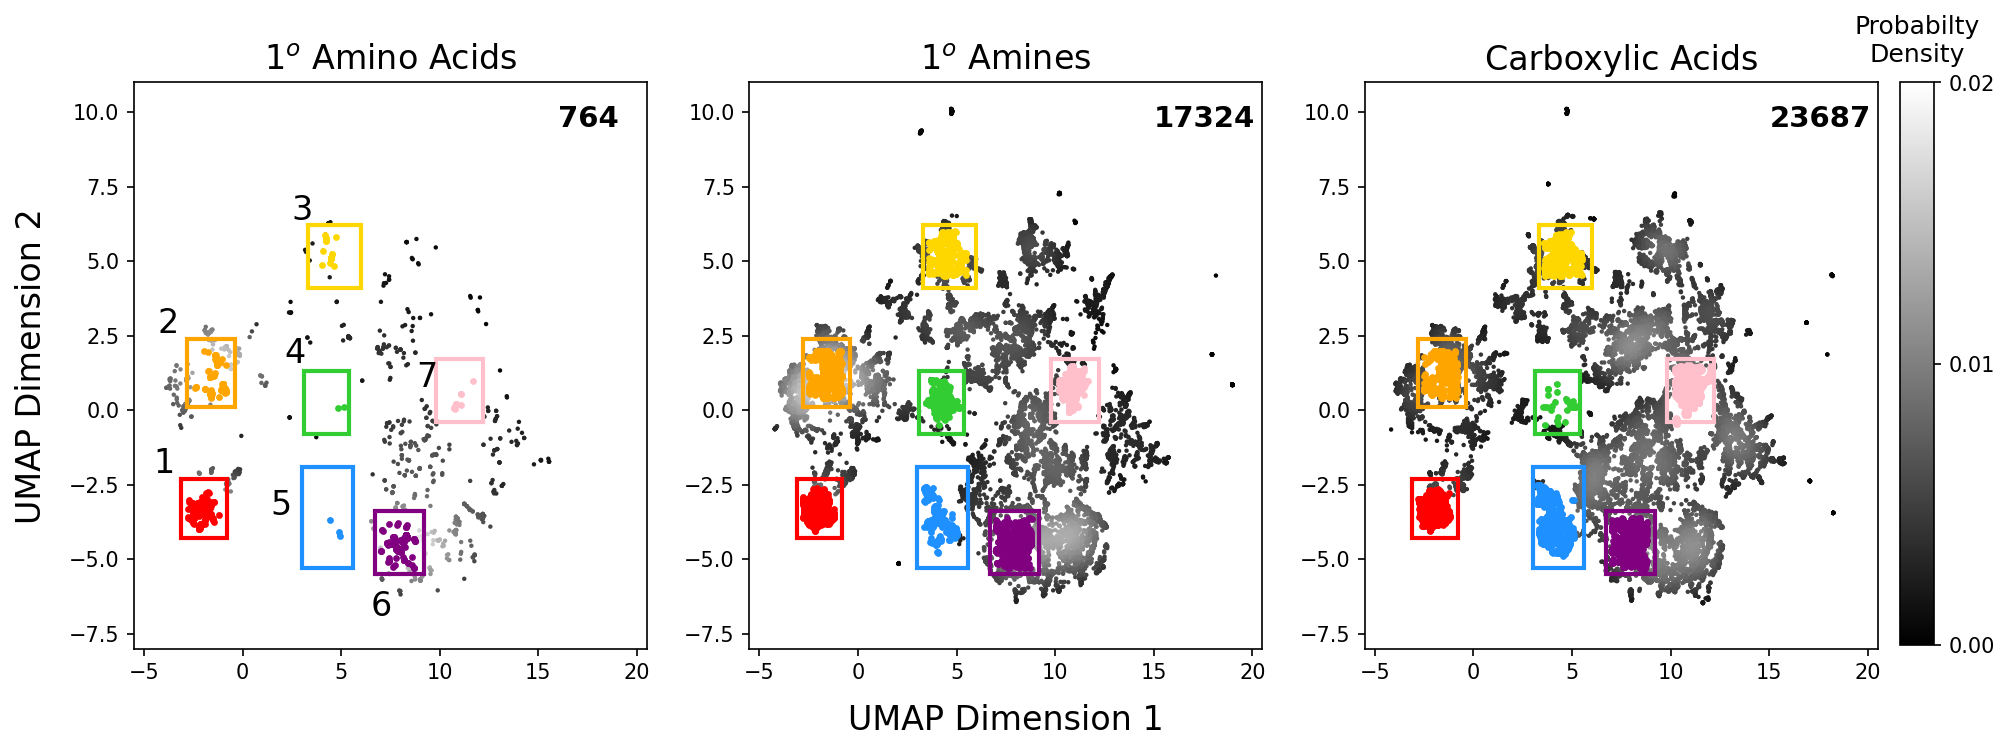

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=150)
for ax in axs.reshape(-1):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

cmapping='gray'

sc = axs[0].scatter(pAA_umap['X'], pAA_umap['Y'], c=z_pAA, s=5, cmap=cmapping, 
                    marker='.', vmin=t_min, vmax=t_max)
axs[1].scatter(pamine_umap['X'], pamine_umap['Y'], c=z_pamine, s=5, cmap=cmapping, 
               marker='.', vmin=t_min, vmax=t_max)
axs[2].scatter(cooh_umap['X'], cooh_umap['Y'], c=z_cooh, s=5, cmap=cmapping, 
               marker='.', vmin=t_min, vmax=t_max)

axs[0].text(16, 9.5, s=f"{len(set(pAA_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[1].text(15, 9.5, s=f"{len(set(pamine_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[2].text(15, 9.5, s=f"{len(set(cooh_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')

axs[1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16)
axs[0].set_ylabel('UMAP Dimension 2', labelpad=10, fontsize=16)

axs[0].scatter(pAA_cluster_1['X'], pAA_cluster_1['Y'], s=5, color='red')
axs[0].scatter(pAA_cluster_2['X'], pAA_cluster_2['Y'], s=5, color='orange')
axs[0].scatter(pAA_cluster_3['X'], pAA_cluster_3['Y'], s=5, color='gold')
axs[0].scatter(pAA_cluster_4['X'], pAA_cluster_4['Y'], s=5, color='limegreen')
axs[0].scatter(pAA_cluster_5['X'], pAA_cluster_5['Y'], s=5, color='dodgerblue')
axs[0].scatter(pAA_cluster_6['X'], pAA_cluster_6['Y'], s=5, color='purple')
axs[0].scatter(pAA_cluster_7['X'], pAA_cluster_7['Y'], s=5, color='pink')

axs[1].scatter(pamine_cluster_1['X'], pamine_cluster_1['Y'], s=5, color='red')
axs[1].scatter(pamine_cluster_2['X'], pamine_cluster_2['Y'], s=5, color='orange')
axs[1].scatter(pamine_cluster_3['X'], pamine_cluster_3['Y'], s=5, color='gold')
axs[1].scatter(pamine_cluster_4['X'], pamine_cluster_4['Y'], s=5, color='limegreen')
axs[1].scatter(pamine_cluster_5['X'], pamine_cluster_5['Y'], s=5, color='dodgerblue')
axs[1].scatter(pamine_cluster_6['X'], pamine_cluster_6['Y'], s=5, color='purple')
axs[1].scatter(pamine_cluster_7['X'], pamine_cluster_7['Y'], s=5, color='pink')

axs[2].scatter(cooh_cluster_1['X'], cooh_cluster_1['Y'], s=5, color='red')
axs[2].scatter(cooh_cluster_2['X'], cooh_cluster_2['Y'], s=5, color='orange')
axs[2].scatter(cooh_cluster_3['X'], cooh_cluster_3['Y'], s=5, color='gold')
axs[2].scatter(cooh_cluster_4['X'], cooh_cluster_4['Y'], s=5, color='limegreen')
axs[2].scatter(cooh_cluster_5['X'], cooh_cluster_5['Y'], s=5, color='dodgerblue')
axs[2].scatter(cooh_cluster_6['X'], cooh_cluster_6['Y'], s=5, color='purple')
axs[2].scatter(cooh_cluster_7['X'], cooh_cluster_7['Y'], s=5, color='pink')

axs[0].set_title("$1^{o}$ Amino Acids", fontsize=16)
axs[1].set_title("$1^{o}$ Amines", fontsize=16)
axs[2].set_title("Carboxylic Acids", fontsize=16)

# Create a Rectangle patch
c1_0 = patches.Rectangle((-3.1, -4.3), 2.3, 2, linewidth=2, edgecolor='red', facecolor='none')
c1_1 = patches.Rectangle((-3.1, -4.3), 2.3, 2, linewidth=2, edgecolor='red', facecolor='none')
c1_2 = patches.Rectangle((-3.1, -4.3), 2.3, 2, linewidth=2, edgecolor='red', facecolor='none')

c2_0 = patches.Rectangle((-2.8, 0.1), 2.4, 2.3, linewidth=2, edgecolor='orange', facecolor='none')
c2_1 = patches.Rectangle((-2.8, 0.1), 2.4, 2.3, linewidth=2, edgecolor='orange', facecolor='none')
c2_2 = patches.Rectangle((-2.8, 0.1), 2.4, 2.3, linewidth=2, edgecolor='orange', facecolor='none')

c3_0 = patches.Rectangle((3.3, 4.1), 2.7, 2.1, linewidth=2, edgecolor='gold', facecolor='none')
c3_1 = patches.Rectangle((3.3, 4.1), 2.7, 2.1, linewidth=2, edgecolor='gold', facecolor='none')
c3_2 = patches.Rectangle((3.3, 4.1), 2.7, 2.1, linewidth=2, edgecolor='gold', facecolor='none')

c4_0 = patches.Rectangle((3.1, -0.8), 2.3, 2.1, linewidth=2, edgecolor='limegreen', facecolor='none')
c4_1 = patches.Rectangle((3.1, -0.8), 2.3, 2.1, linewidth=2, edgecolor='limegreen', facecolor='none')
c4_2 = patches.Rectangle((3.1, -0.8), 2.3, 2.1, linewidth=2, edgecolor='limegreen', facecolor='none')

c5_0 = patches.Rectangle((3, -5.3), 2.6, 3.4, linewidth=2, edgecolor='dodgerblue', facecolor='none')
c5_1 = patches.Rectangle((3, -5.3), 2.6, 3.4, linewidth=2, edgecolor='dodgerblue', facecolor='none')
c5_2 = patches.Rectangle((3, -5.3), 2.6, 3.4, linewidth=2, edgecolor='dodgerblue', facecolor='none')

c6_0 = patches.Rectangle((6.7, -5.5), 2.5, 2.1, linewidth=2, edgecolor='purple', facecolor='none')
c6_1 = patches.Rectangle((6.7, -5.5), 2.5, 2.1, linewidth=2, edgecolor='purple', facecolor='none')
c6_2 = patches.Rectangle((6.7, -5.5), 2.5, 2.1, linewidth=2, edgecolor='purple', facecolor='none')

c7_0 = patches.Rectangle((9.8, -0.4), 2.4, 2.1, linewidth=2, edgecolor='pink', facecolor='none')
c7_1 = patches.Rectangle((9.8, -0.4), 2.4, 2.1, linewidth=2, edgecolor='pink', facecolor='none')
c7_2 = patches.Rectangle((9.8, -0.4), 2.4, 2.1, linewidth=2, edgecolor='pink', facecolor='none')

# Add the patch to the Axes
axs[0].add_patch(c1_0)
axs[1].add_patch(c1_1)
axs[2].add_patch(c1_2)

axs[0].add_patch(c2_0)
axs[1].add_patch(c2_1)
axs[2].add_patch(c2_2)

axs[0].add_patch(c3_0)
axs[1].add_patch(c3_1)
axs[2].add_patch(c3_2)

axs[0].add_patch(c4_0)
axs[1].add_patch(c4_1)
axs[2].add_patch(c4_2)

axs[0].add_patch(c5_0)
axs[1].add_patch(c5_1)
axs[2].add_patch(c5_2)

axs[0].add_patch(c6_0)
axs[1].add_patch(c6_1)
axs[2].add_patch(c6_2)

axs[0].add_patch(c7_0)
axs[1].add_patch(c7_1)
axs[2].add_patch(c7_2)

axs[0].text(-4.5, -2.1, '1', fontsize=16)
axs[0].text(-4.3, 2.6, '2', fontsize=16)
axs[0].text(2.5, 6.4, '3', fontsize=16)
axs[0].text(2.1, 1.6, '4', fontsize=16)
axs[0].text(1.4, -3.5, '5', fontsize=16)
axs[0].text(6.5, -6.9, '6', fontsize=16)
axs[0].text(8.8, 0.8, '7', fontsize=16)

n_ticks = 3
cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
cbar_ax.set_title("Probabilty\nDensity", pad=10)

cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_ticks(np.linspace(t_min, t_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(t_min, t_max, n_ticks)])

#fig.savefig('../../figures/figure_2.png')
#fig.savefig('../../figures/figure_2.svg')
plt.show()

### Sample structures from cluster 1 

Number of shared truncates in cluster 1: 78


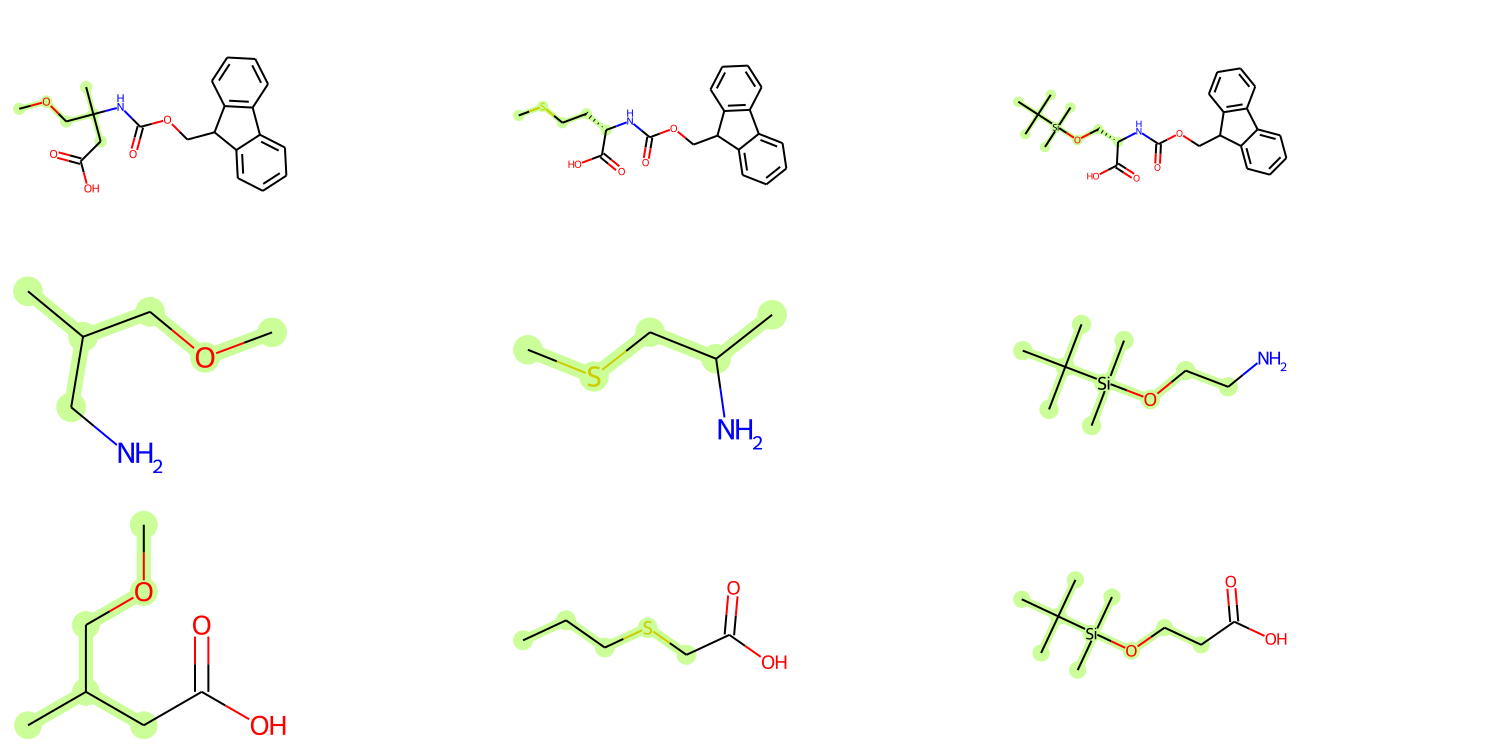

In [14]:
c1_pAA = find_truncates(pAA_umap, c1_xmin, c1_xmax, c1_ymin, c1_ymax)
c1_pamine = find_truncates(pamine_umap, c1_xmin, c1_xmax, c1_ymin, c1_ymax)
c1_cooh = find_truncates(cooh_umap, c1_xmin, c1_xmax, c1_ymin, c1_ymax)

c1_truncates = cluster_truncates(c1_pAA, c1_pamine, c1_cooh)
print('Number of shared truncates in cluster 1:', len(c1_truncates))
c1_list = [c1_pAA, c1_pamine, c1_cooh]
display_Image(draw_multiple(c1_truncates[:3], c1_list, '../../figures/c1_truncates.png'))

### Sample structures from cluster 2

Number of shared truncates in cluster 2: 49


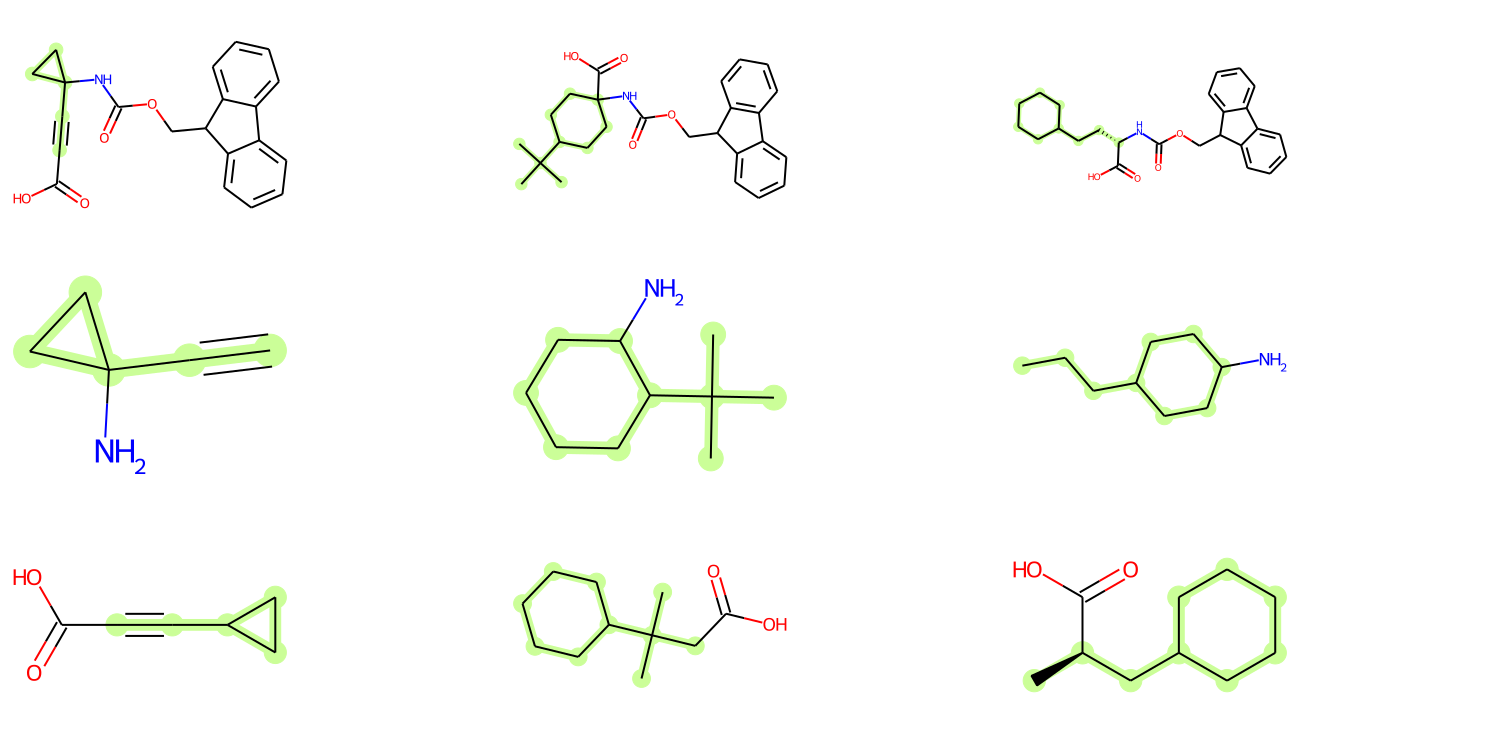

In [15]:
c2_pAA = find_truncates(pAA_umap, c2_xmin, c2_xmax, c2_ymin, c2_ymax)
c2_pamine = find_truncates(pamine_umap, c2_xmin, c2_xmax, c2_ymin, c2_ymax)
c2_cooh = find_truncates(cooh_umap, c2_xmin, c2_xmax, c2_ymin, c2_ymax)

c2_truncates = cluster_truncates(c2_pAA, c2_pamine, c2_cooh)
print('Number of shared truncates in cluster 2:', len(c2_truncates))
c2_list = [c2_pAA, c2_pamine, c2_cooh]
display_Image(draw_multiple(c2_truncates[:3], c2_list, '../../figures/c2_truncates.png'))

### Sample structures from cluster 3

Number of shared truncates in cluster 3: 8


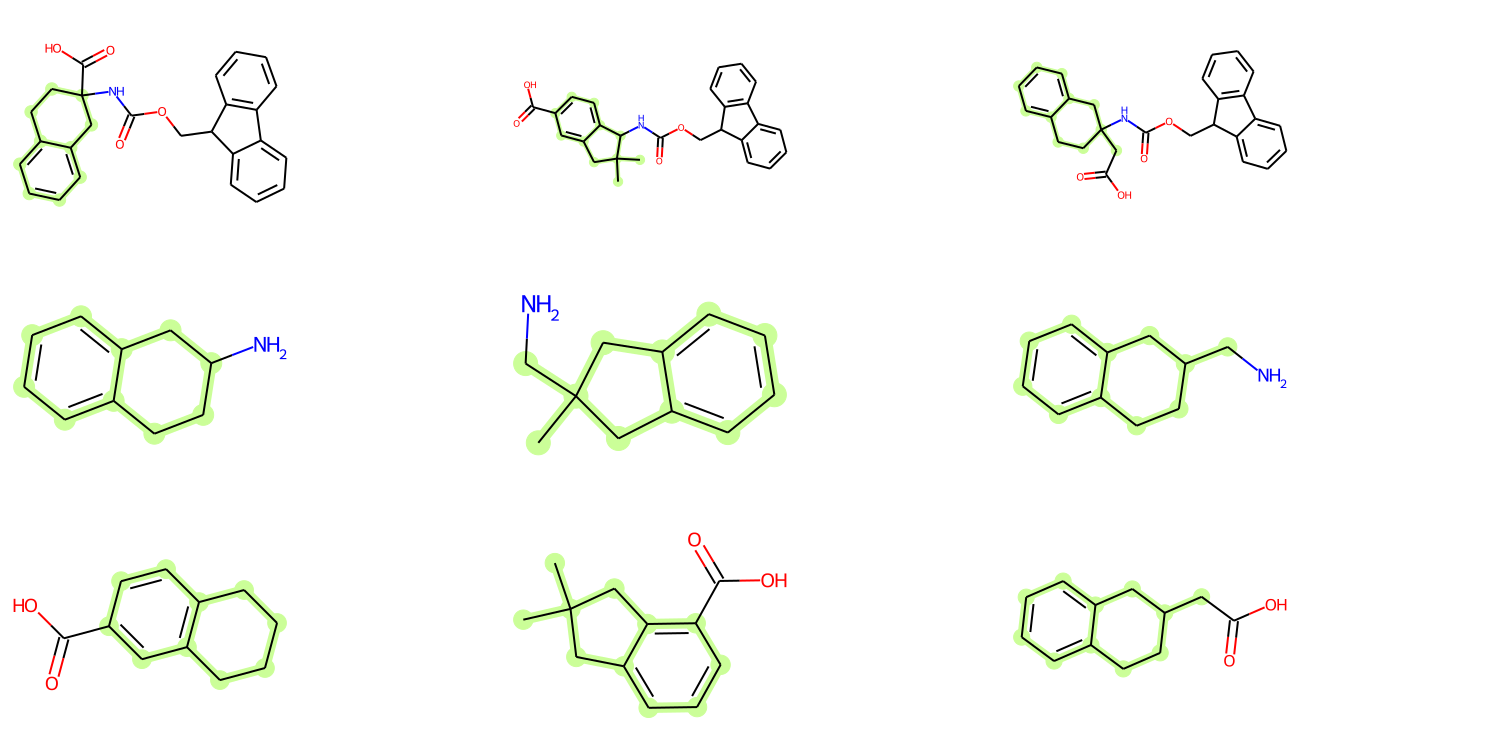

In [16]:
c3_pAA = find_truncates(pAA_umap, c3_xmin, c3_xmax, c3_ymin, c3_ymax)
c3_pamine = find_truncates(pamine_umap, c3_xmin, c3_xmax, c3_ymin, c3_ymax)
c3_cooh = find_truncates(cooh_umap, c3_xmin, c3_xmax, c3_ymin, c3_ymax)

c3_truncates = cluster_truncates(c3_pAA, c3_pamine, c3_cooh)
print('Number of shared truncates in cluster 3:', len(c3_truncates))
c3_list = [c3_pAA, c3_pamine, c3_cooh]
display_Image(draw_multiple(c3_truncates[:3], c3_list, '../../figures/c3_truncates.png'))

### Sample structures from cluster 4

Number of shared truncates in cluster 4: 1


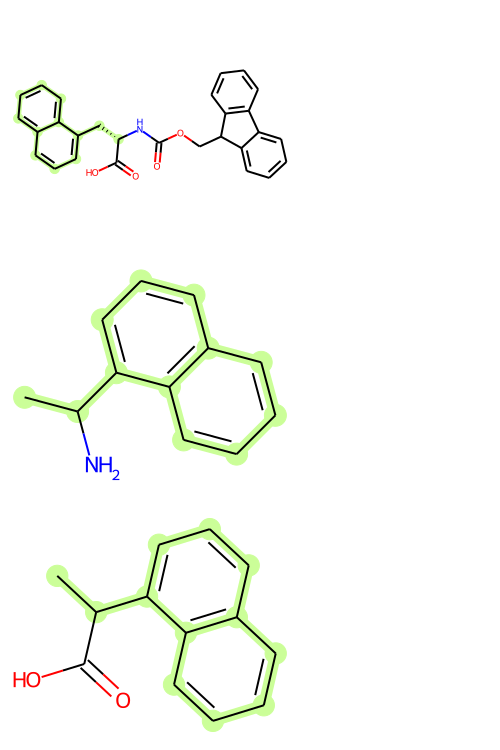

In [17]:
c4_pAA = find_truncates(pAA_umap, c4_xmin, c4_xmax, c4_ymin, c4_ymax)
c4_pamine = find_truncates(pamine_umap, c4_xmin, c4_xmax, c4_ymin, c4_ymax)
c4_cooh = find_truncates(cooh_umap, c4_xmin, c4_xmax, c4_ymin, c4_ymax)

c4_truncates = cluster_truncates(c4_pAA, c4_pamine, c4_cooh)
print('Number of shared truncates in cluster 4:', len(c4_truncates))
c4_list = [c4_pAA, c4_pamine, c4_cooh]
display_Image(draw_multiple(c4_truncates, c4_list, '../../figures/c4_truncates.png'))

### Sample structures from cluster 5

Number of shared truncates in cluster 5: 1


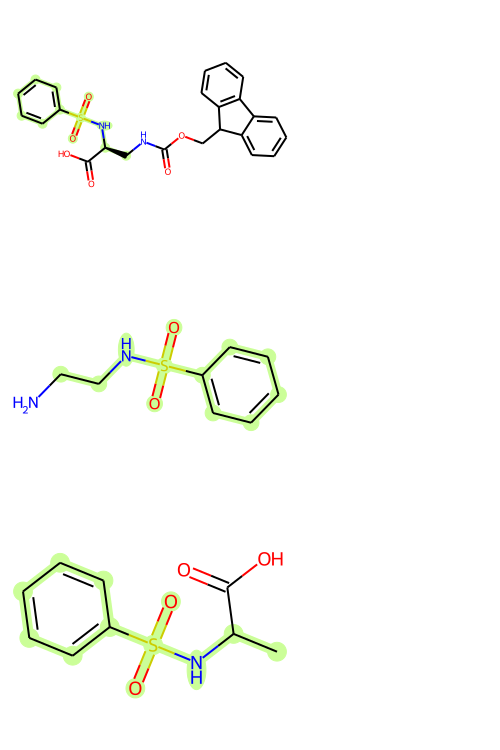

In [18]:
c5_pAA = find_truncates(pAA_umap, c5_xmin, c5_xmax, c5_ymin, c5_ymax)
c5_pamine = find_truncates(pamine_umap, c5_xmin, c5_xmax, c5_ymin, c5_ymax)
c5_cooh = find_truncates(cooh_umap, c5_xmin, c5_xmax, c5_ymin, c5_ymax)

c5_truncates = cluster_truncates(c5_pAA, c5_pamine, c5_cooh)
print('Number of shared truncates in cluster 5:', len(c5_truncates))
c5_list = [c5_pAA, c5_pamine, c5_cooh]
display_Image(draw_multiple(c5_truncates, c5_list, '../../figures/c5_truncates.png'))

### Sample structures from cluster 6

Number of shared truncates in cluster 6: 53


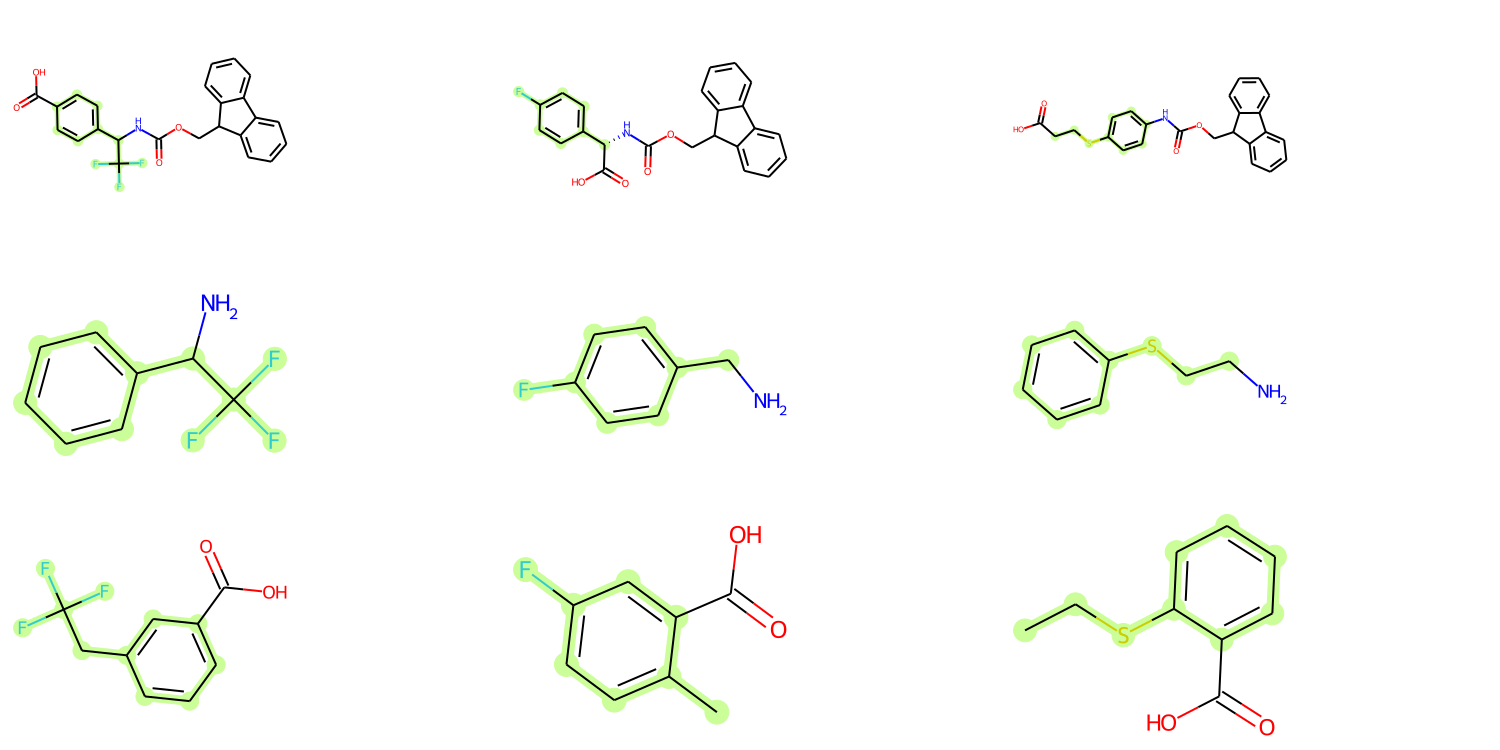

In [19]:
c6_pAA = find_truncates(pAA_umap, c6_xmin, c6_xmax, c6_ymin, c6_ymax)
c6_pamine = find_truncates(pamine_umap, c6_xmin, c6_xmax, c6_ymin, c6_ymax)
c6_cooh = find_truncates(cooh_umap, c6_xmin, c6_xmax, c6_ymin, c6_ymax)

c6_truncates = cluster_truncates(c6_pAA, c6_pamine, c6_cooh)
print('Number of shared truncates in cluster 6:', len(c6_truncates))

c6_list = [c6_pAA, c6_pamine, c6_cooh]
display_Image(draw_multiple(c6_truncates[3:6], c6_list, '../../figures/c6_truncates.png'))

### Sample structures from cluster 7

Number of shared truncates in cluster 7: 4


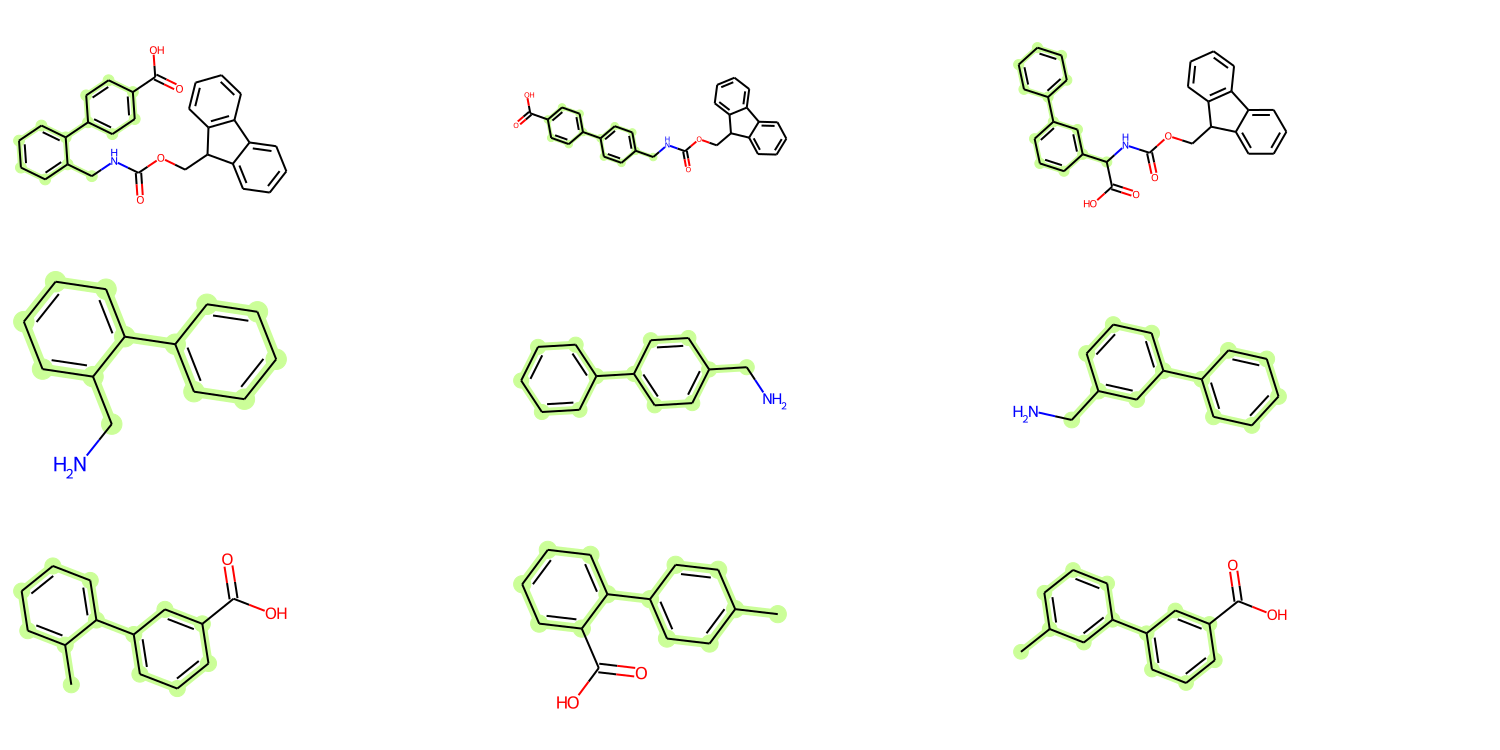

In [20]:
c7_pAA = find_truncates(pAA_umap, c7_xmin, c7_xmax, c7_ymin, c7_ymax)
c7_pamine = find_truncates(pamine_umap, c7_xmin, c7_xmax, c7_ymin, c7_ymax)
c7_cooh = find_truncates(cooh_umap, c7_xmin, c7_xmax, c7_ymin, c7_ymax)

c7_truncates = cluster_truncates(c7_pAA, c7_pamine, c7_cooh)
print('Number of shared truncates in cluster 7:', len(c7_truncates))
c7_list = [c7_pAA, c7_pamine, c7_cooh]
display_Image(draw_multiple(c7_truncates[:3], c7_list, '../../figures/c7_truncates.png'))

### Figure 3: Building block cost filtering 

In [21]:
pamine_100 = pamine_umap.loc[pamine_umap['Price_250mg'] <= 100].drop_duplicates(subset='truncate_SMILES')
pamine_250 = pamine_umap.loc[pamine_umap['Price_250mg'] <= 250].drop_duplicates(subset='truncate_SMILES')
pamine_500 = pamine_umap.loc[pamine_umap['Price_250mg'] <= 500].drop_duplicates(subset='truncate_SMILES')

pAA_100 = pAA_umap.loc[pAA_umap['Price_250mg'] <= 100].drop_duplicates(subset='truncate_SMILES')
pAA_250 = pAA_umap.loc[pAA_umap['Price_250mg'] <= 250].drop_duplicates(subset='truncate_SMILES')
pAA_500 = pAA_umap.loc[pAA_umap['Price_250mg'] <= 500].drop_duplicates(subset='truncate_SMILES')

cooh_100 = cooh_umap.loc[cooh_umap['Price_250mg'] <= 100].drop_duplicates(subset='truncate_SMILES')
cooh_250 = cooh_umap.loc[cooh_umap['Price_250mg'] <= 250].drop_duplicates(subset='truncate_SMILES')
cooh_500 = cooh_umap.loc[cooh_umap['Price_250mg'] <= 500].drop_duplicates(subset='truncate_SMILES')

In [22]:
z_pamine_100 = kde_(pamine_100)
z_pamine_250 = kde_(pamine_250)
z_pamine_500 = kde_(pamine_500)

z_pAA_100 = kde_(pAA_100)
z_pAA_250 = kde_(pAA_250)
z_pAA_500 = kde_(pAA_500)

z_cooh_100 = kde_(cooh_100)
z_cooh_250 = kde_(cooh_250)
z_cooh_500 = kde_(cooh_500)

In [23]:
cost_z_min = np.min([np.min(z_cooh_100), np.min(z_pAA_100), np.min(z_pamine_100),
          np.min(z_cooh_250), np.min(z_pAA_250), np.min(z_pamine_250),
          np.min(z_cooh_500), np.min(z_pAA_500), np.min(z_pamine_500)])

cost_z_max = np.max([np.max(z_cooh_100), np.max(z_pAA_100), np.max(z_pamine_100),
           np.max(z_cooh_250), np.max(z_pAA_250), np.max(z_pamine_250),
           np.max(z_cooh_500), np.max(z_pAA_500), np.max(z_pamine_500)])

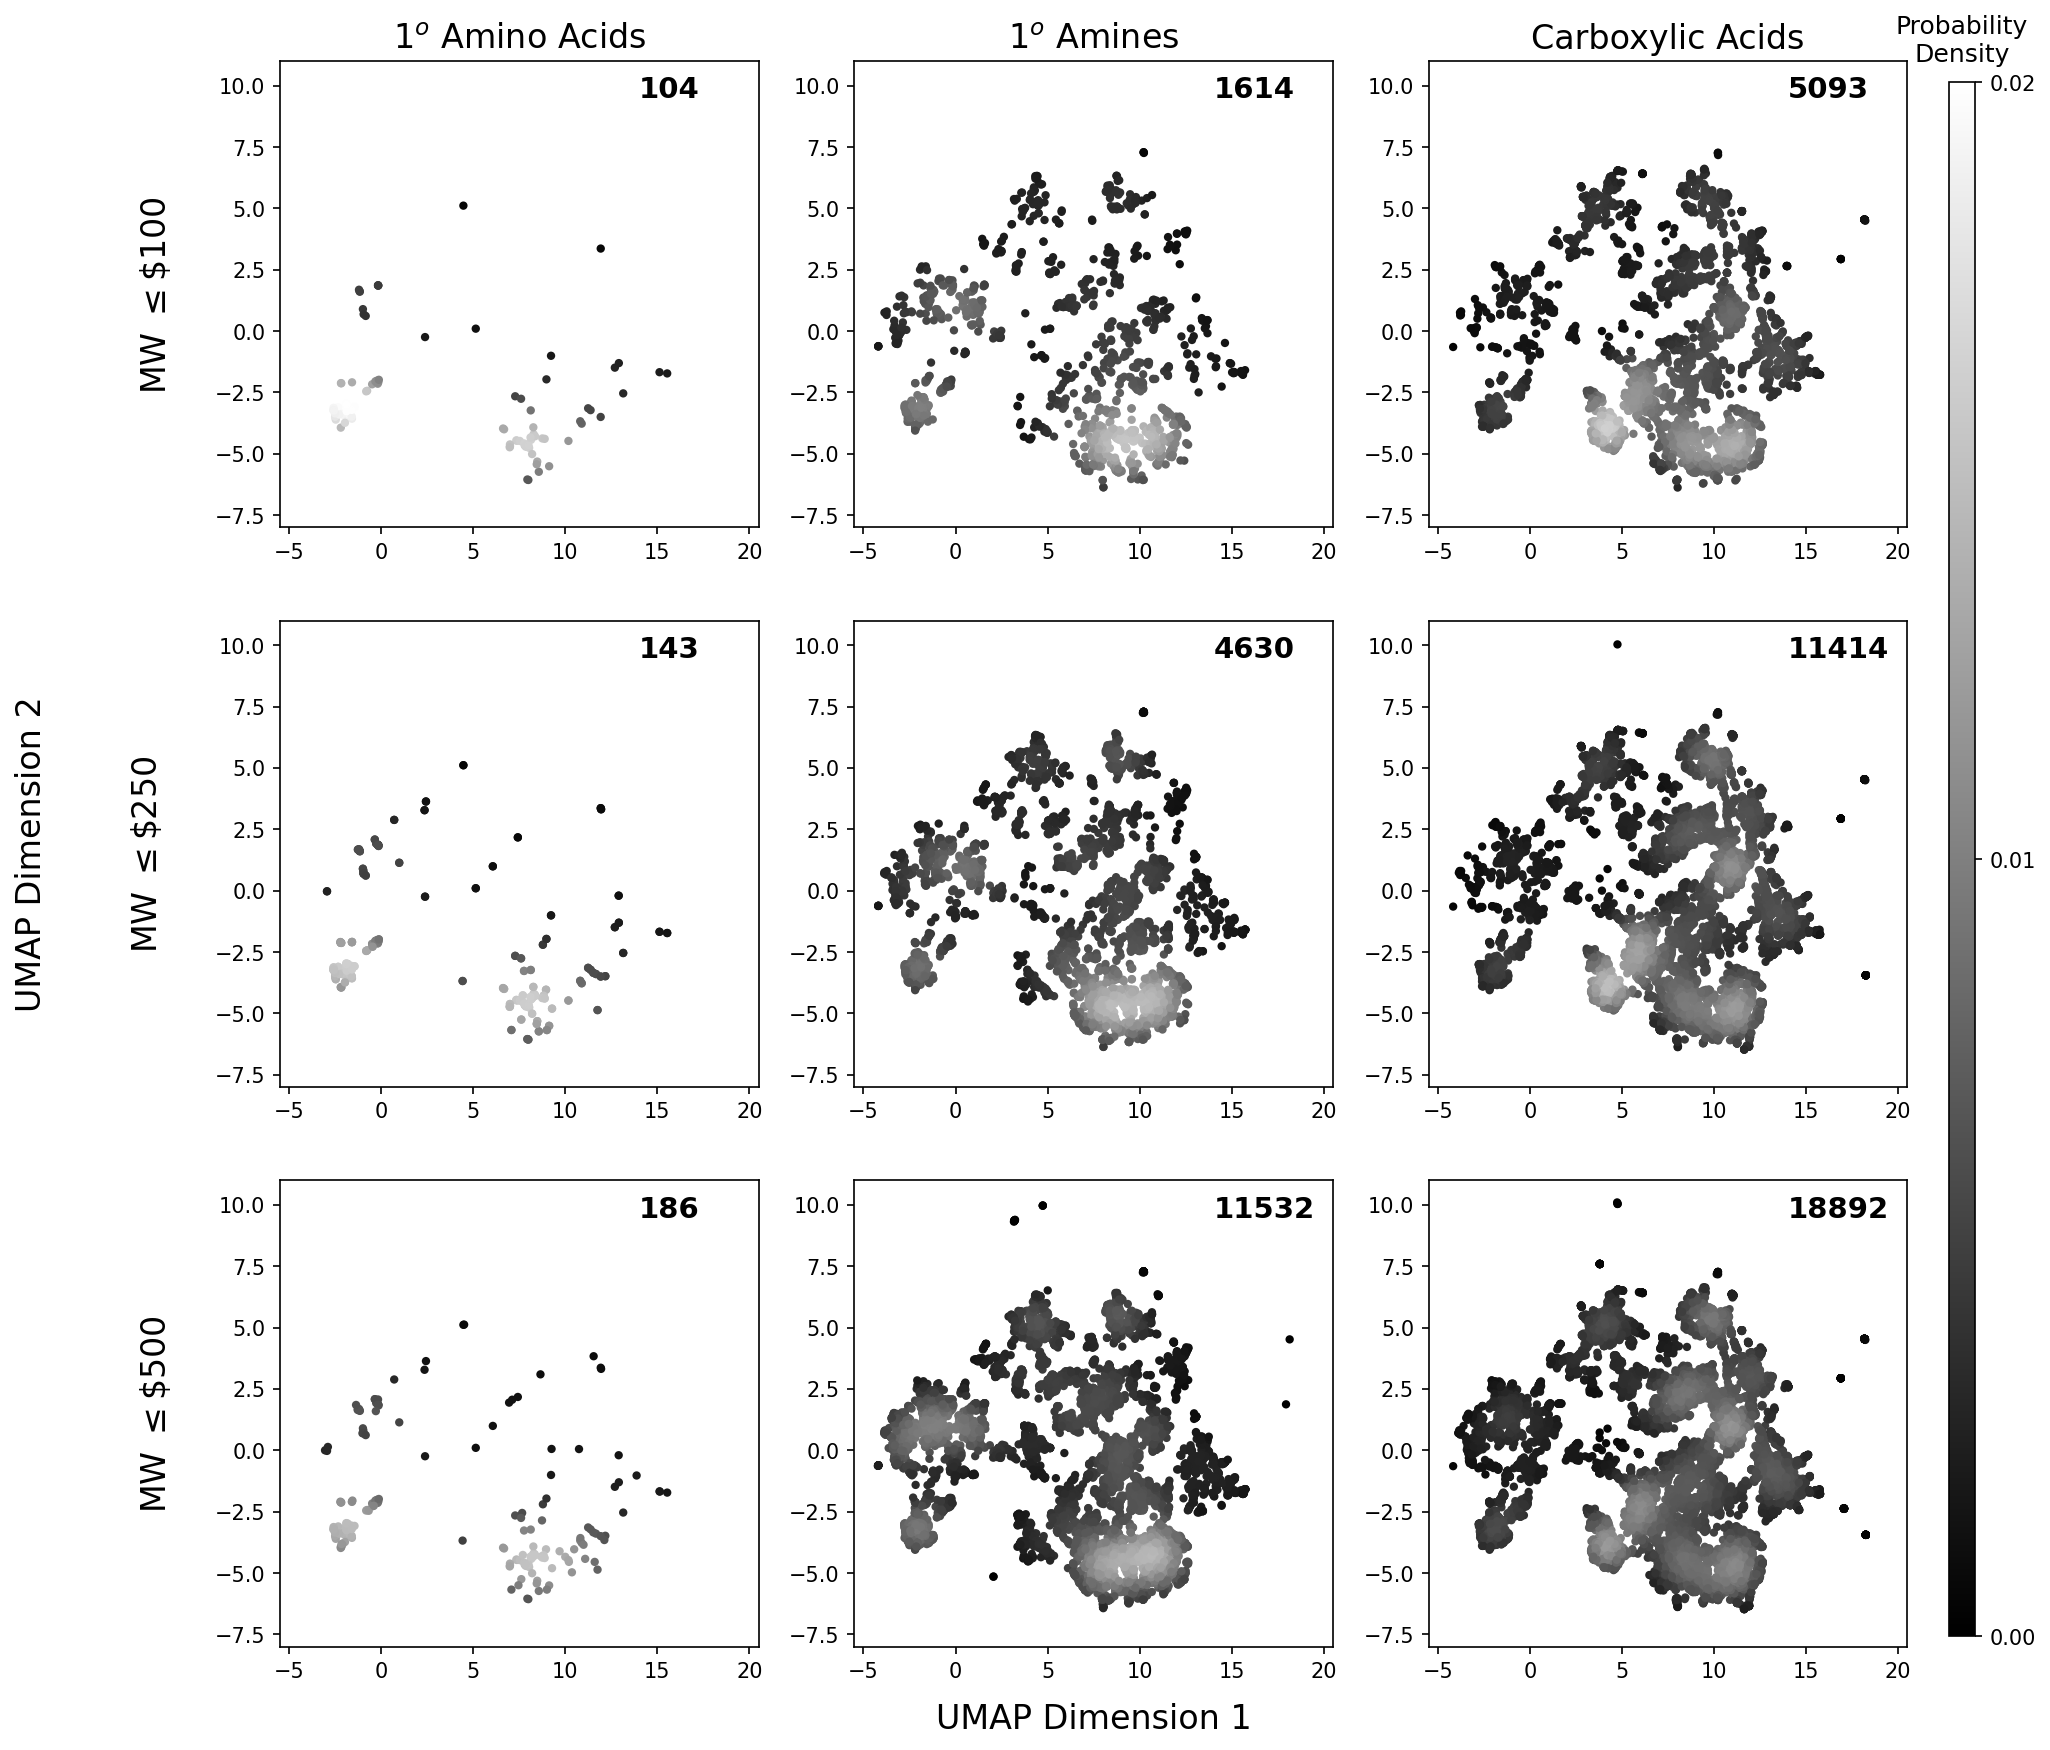

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(14,14), dpi=150)
cost_list = [pAA_100, pamine_100, cooh_100,
             pAA_250, pamine_250, cooh_250,
             pAA_500, pamine_500, cooh_500]

z_list = [z_pAA_100, z_pamine_100, z_cooh_100,
          z_pAA_250, z_pamine_250, z_cooh_250,
          z_pAA_500, z_pamine_500, z_cooh_500]


for index, ax in enumerate(axs.reshape(-1)):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(cost_list[index]['X'], cost_list[index]['Y'], c=z_list[index],
               cmap='gray', marker='.', vmin=cost_z_min, vmax=cost_z_max)
    ax.text(14, 9.5, f"{len(set(cost_list[index]['truncate_SMILES']))}", fontweight='bold', fontsize=14)
    
sc1 = axs[1][0].scatter(pAA_250['X'], pAA_250['Y'], c=z_pAA_250, cmap='gray', marker='.',
                       vmin=cost_z_min, vmax=cost_z_max)
    
axs[0][0].set_title('$1^{o}$ Amino Acids', fontsize=16)
axs[0][1].set_title('$1^{o}$ Amines', fontsize=16)
axs[0][2].set_title('Carboxylic Acids', fontsize=16)

axs[0][0].set_ylabel('MW $\leq \$100$', rotation=90, labelpad=20, fontsize=16)
axs[1][0].set_ylabel('UMAP Dimension 2', labelpad=80, fontsize=16)
axs[1][1].set_ylabel('MW $\leq \$250$', rotation=90, labelpad=300, fontsize=16)

axs[2][0].set_ylabel('MW $\leq \$500$', rotation=90, labelpad=20, fontsize=16)
axs[2][1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16)

n_ticks = 3
cbar_ax = fig.add_axes([0.92, 0.13, 0.012, 0.74])
cbar_ax.set_title("Probability\nDensity", pad=10)
cbar = plt.colorbar(sc1, cax=cbar_ax)
cbar.set_ticks(np.linspace(cost_z_min, cost_z_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(cost_z_min, cost_z_max, n_ticks)])

#fig.savefig('../../figures/figure_3.png')
#fig.savefig('../../figures/figure_3.svg')
plt.show()

### Figure 4: PCP filtering for building blocks (not truncates)

In [25]:
pg_dict = pickle.load(open('../data_prep/PG_SMILES.pkl', 'rb'))
pg_smirks = pickle.load(open('../data_prep/deprot_SMIRKS.pkl', 'rb'))

#### $1^{o}$ Amino Acids

In [26]:
# Need to adjust MW calcs for BBs containing protecting groups
pAA_umap['fmoc'] = pAA_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['fmoc']))
pAA_umap['nboc'] = pAA_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['nboc']))

In [27]:
print('Number of primary amino acid BBs with Fmoc:', len(pAA_umap.loc[pAA_umap['fmoc'] == True]))
print('Number of primary amino acid BBs with Nboc:', len(pAA_umap.loc[pAA_umap['nboc'] == True]))

Number of primary amino acid BBs with Fmoc: 1396
Number of primary amino acid BBs with Nboc: 0


In [28]:
# Remove protecting groups
pAA_umap['deprot_smi'] = pAA_umap['BB_SMILES'].apply(lambda smi: deprotectGroup(smi, pg_smirks['fmoc']))

In [29]:
# Calculate various physicochemical properties
pAA_mols = make_molecules(pAA_umap['deprot_smi'])
pAA_umap['molecules'] = pAA_mols
pAA_umap['mw'] = pAA_umap['molecules'].apply(oechem.OECalculateMolecularWeight)
pAA_umap['tpsa'] = pAA_umap['molecules'].apply(oemolprop.OEGet2dPSA)
pAA_umap['hbd'] = pAA_umap['molecules'].apply(oemolprop.OEGetHBondDonorCount)
pAA_umap['hba'] = pAA_umap['molecules'].apply(oemolprop.OEGetHBondAcceptorCount)

pAA_xlogp = np.ones(len(pAA_umap)) * 100
for i in range(len(pAA_umap)):
    mol = pAA_umap['molecules'].iloc[i]
    try:
        pAA_xlogp[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
pAA_umap['xlogp'] = pAA_xlogp

#### $1^{o}$ Amines

In [30]:
# Need to adjust MW calcs for BBs containing protecting groups
pamine_umap['fmoc'] = pamine_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['fmoc']))
pamine_umap['nboc'] = pamine_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['nboc']))

In [31]:
print('Number of primary amine BBs with Fmoc:', len(pamine_umap.loc[pamine_umap['fmoc'] == True]))
print('Number of primary amine BBs with Nboc:', len(pamine_umap.loc[pamine_umap['nboc'] == True]))

Number of primary amine BBs with Fmoc: 0
Number of primary amine BBs with Nboc: 0


In [32]:
# Calculate various physicochemical properties
pamine_mols = make_molecules(pamine_umap['BB_SMILES'])
pamine_umap['molecules'] = pamine_mols
pamine_umap['mw'] = pamine_umap['molecules'].apply(oechem.OECalculateMolecularWeight)
pamine_umap['tpsa'] = pamine_umap['molecules'].apply(oemolprop.OEGet2dPSA)
pamine_umap['hbd'] = pamine_umap['molecules'].apply(oemolprop.OEGetHBondDonorCount)
pamine_umap['hba'] = pamine_umap['molecules'].apply(oemolprop.OEGetHBondAcceptorCount)

pamine_xlogp = np.ones(len(pamine_umap)) * 100
for i in range(len(pamine_umap)):
    mol = pamine_umap['molecules'].iloc[i]
    try:
        pamine_xlogp[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
pamine_umap['xlogp'] = pamine_xlogp

#### Carboxylic acids

In [33]:
## Need to adjust MW calcs for BBs containing protecting groups
cooh_umap['fmoc'] = cooh_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['fmoc']))
cooh_umap['nboc'] = cooh_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['nboc']))

In [34]:
print('Number of carboxylic acid BBs with Fmoc:', len(cooh_umap.loc[cooh_umap['fmoc'] == True]))
print('Number of carboxylic acid BBs with Nboc:', len(cooh_umap.loc[cooh_umap['nboc'] == True]))

Number of carboxylic acid BBs with Fmoc: 0
Number of carboxylic acid BBs with Nboc: 0


In [35]:
# Calculate physicochemical properties
cooh_mols = make_molecules(cooh_umap['BB_SMILES'])
cooh_umap['molecules'] = cooh_mols
cooh_umap['mw'] = cooh_umap['molecules'].apply(oechem.OECalculateMolecularWeight)
cooh_umap['tpsa'] = cooh_umap['molecules'].apply(oemolprop.OEGet2dPSA)
cooh_umap['hbd'] = cooh_umap['molecules'].apply(oemolprop.OEGetHBondDonorCount)
cooh_umap['hba'] = cooh_umap['molecules'].apply(oemolprop.OEGetHBondAcceptorCount)

cooh_xlogp = np.ones(len(cooh_umap)) * 100
for i in range(len(cooh_umap)):
    mol = cooh_umap['molecules'].iloc[i]
    try:
        cooh_xlogp[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
cooh_umap['xlogp'] = cooh_xlogp

In [36]:
## Implement MW filters (MW: <=200, <=250, <=300)

pamine_mw200 = pamine_umap.loc[pamine_umap['mw'] <= 200].drop_duplicates(subset='truncate_SMILES')
pamine_mw250 = pamine_umap.loc[pamine_umap['mw'] <= 250].drop_duplicates(subset='truncate_SMILES')
pamine_mw300 = pamine_umap.loc[pamine_umap['mw'] <= 300].drop_duplicates(subset='truncate_SMILES')

pAA_mw200 = pAA_umap.loc[pAA_umap['mw'] <= 200].drop_duplicates(subset='truncate_SMILES')
pAA_mw250 = pAA_umap.loc[pAA_umap['mw'] <= 250].drop_duplicates(subset='truncate_SMILES')
pAA_mw300 = pAA_umap.loc[pAA_umap['mw'] <= 300].drop_duplicates(subset='truncate_SMILES')

cooh_mw200 = cooh_umap.loc[cooh_umap['mw'] <= 200].drop_duplicates(subset='truncate_SMILES')
cooh_mw250 = cooh_umap.loc[cooh_umap['mw'] <= 250].drop_duplicates(subset='truncate_SMILES')
cooh_mw300 = cooh_umap.loc[cooh_umap['mw'] <= 300].drop_duplicates(subset='truncate_SMILES')

In [37]:
z_pamine_mw200 = kde_(pamine_mw200)
z_pamine_mw250 = kde_(pamine_mw250)
z_pamine_mw300 = kde_(pamine_mw300)

z_pAA_mw200 = kde_(pAA_mw200)
z_pAA_mw250 = kde_(pAA_mw250)
z_pAA_mw300 = kde_(pAA_mw300)

z_cooh_mw200 = kde_(cooh_mw200)
z_cooh_mw250 = kde_(cooh_mw250)
z_cooh_mw300 = kde_(cooh_mw300)

In [38]:
z_mw_min = np.min([np.min(z_cooh_mw200), np.min(z_pAA_mw200), np.min(z_pamine_mw200),
          np.min(z_cooh_mw250), np.min(z_pAA_mw250), np.min(z_pamine_mw250),
          np.min(z_cooh_mw300), np.min(z_pAA_mw300), np.min(z_pamine_mw300)])

z_mw_max = np.max([np.max(z_cooh_mw200), np.max(z_pAA_mw200), np.max(z_pamine_mw200),
           np.max(z_cooh_mw250), np.max(z_pAA_mw250), np.max(z_pamine_mw250),
           np.max(z_cooh_mw300), np.max(z_pAA_mw300), np.max(z_pamine_mw300)])

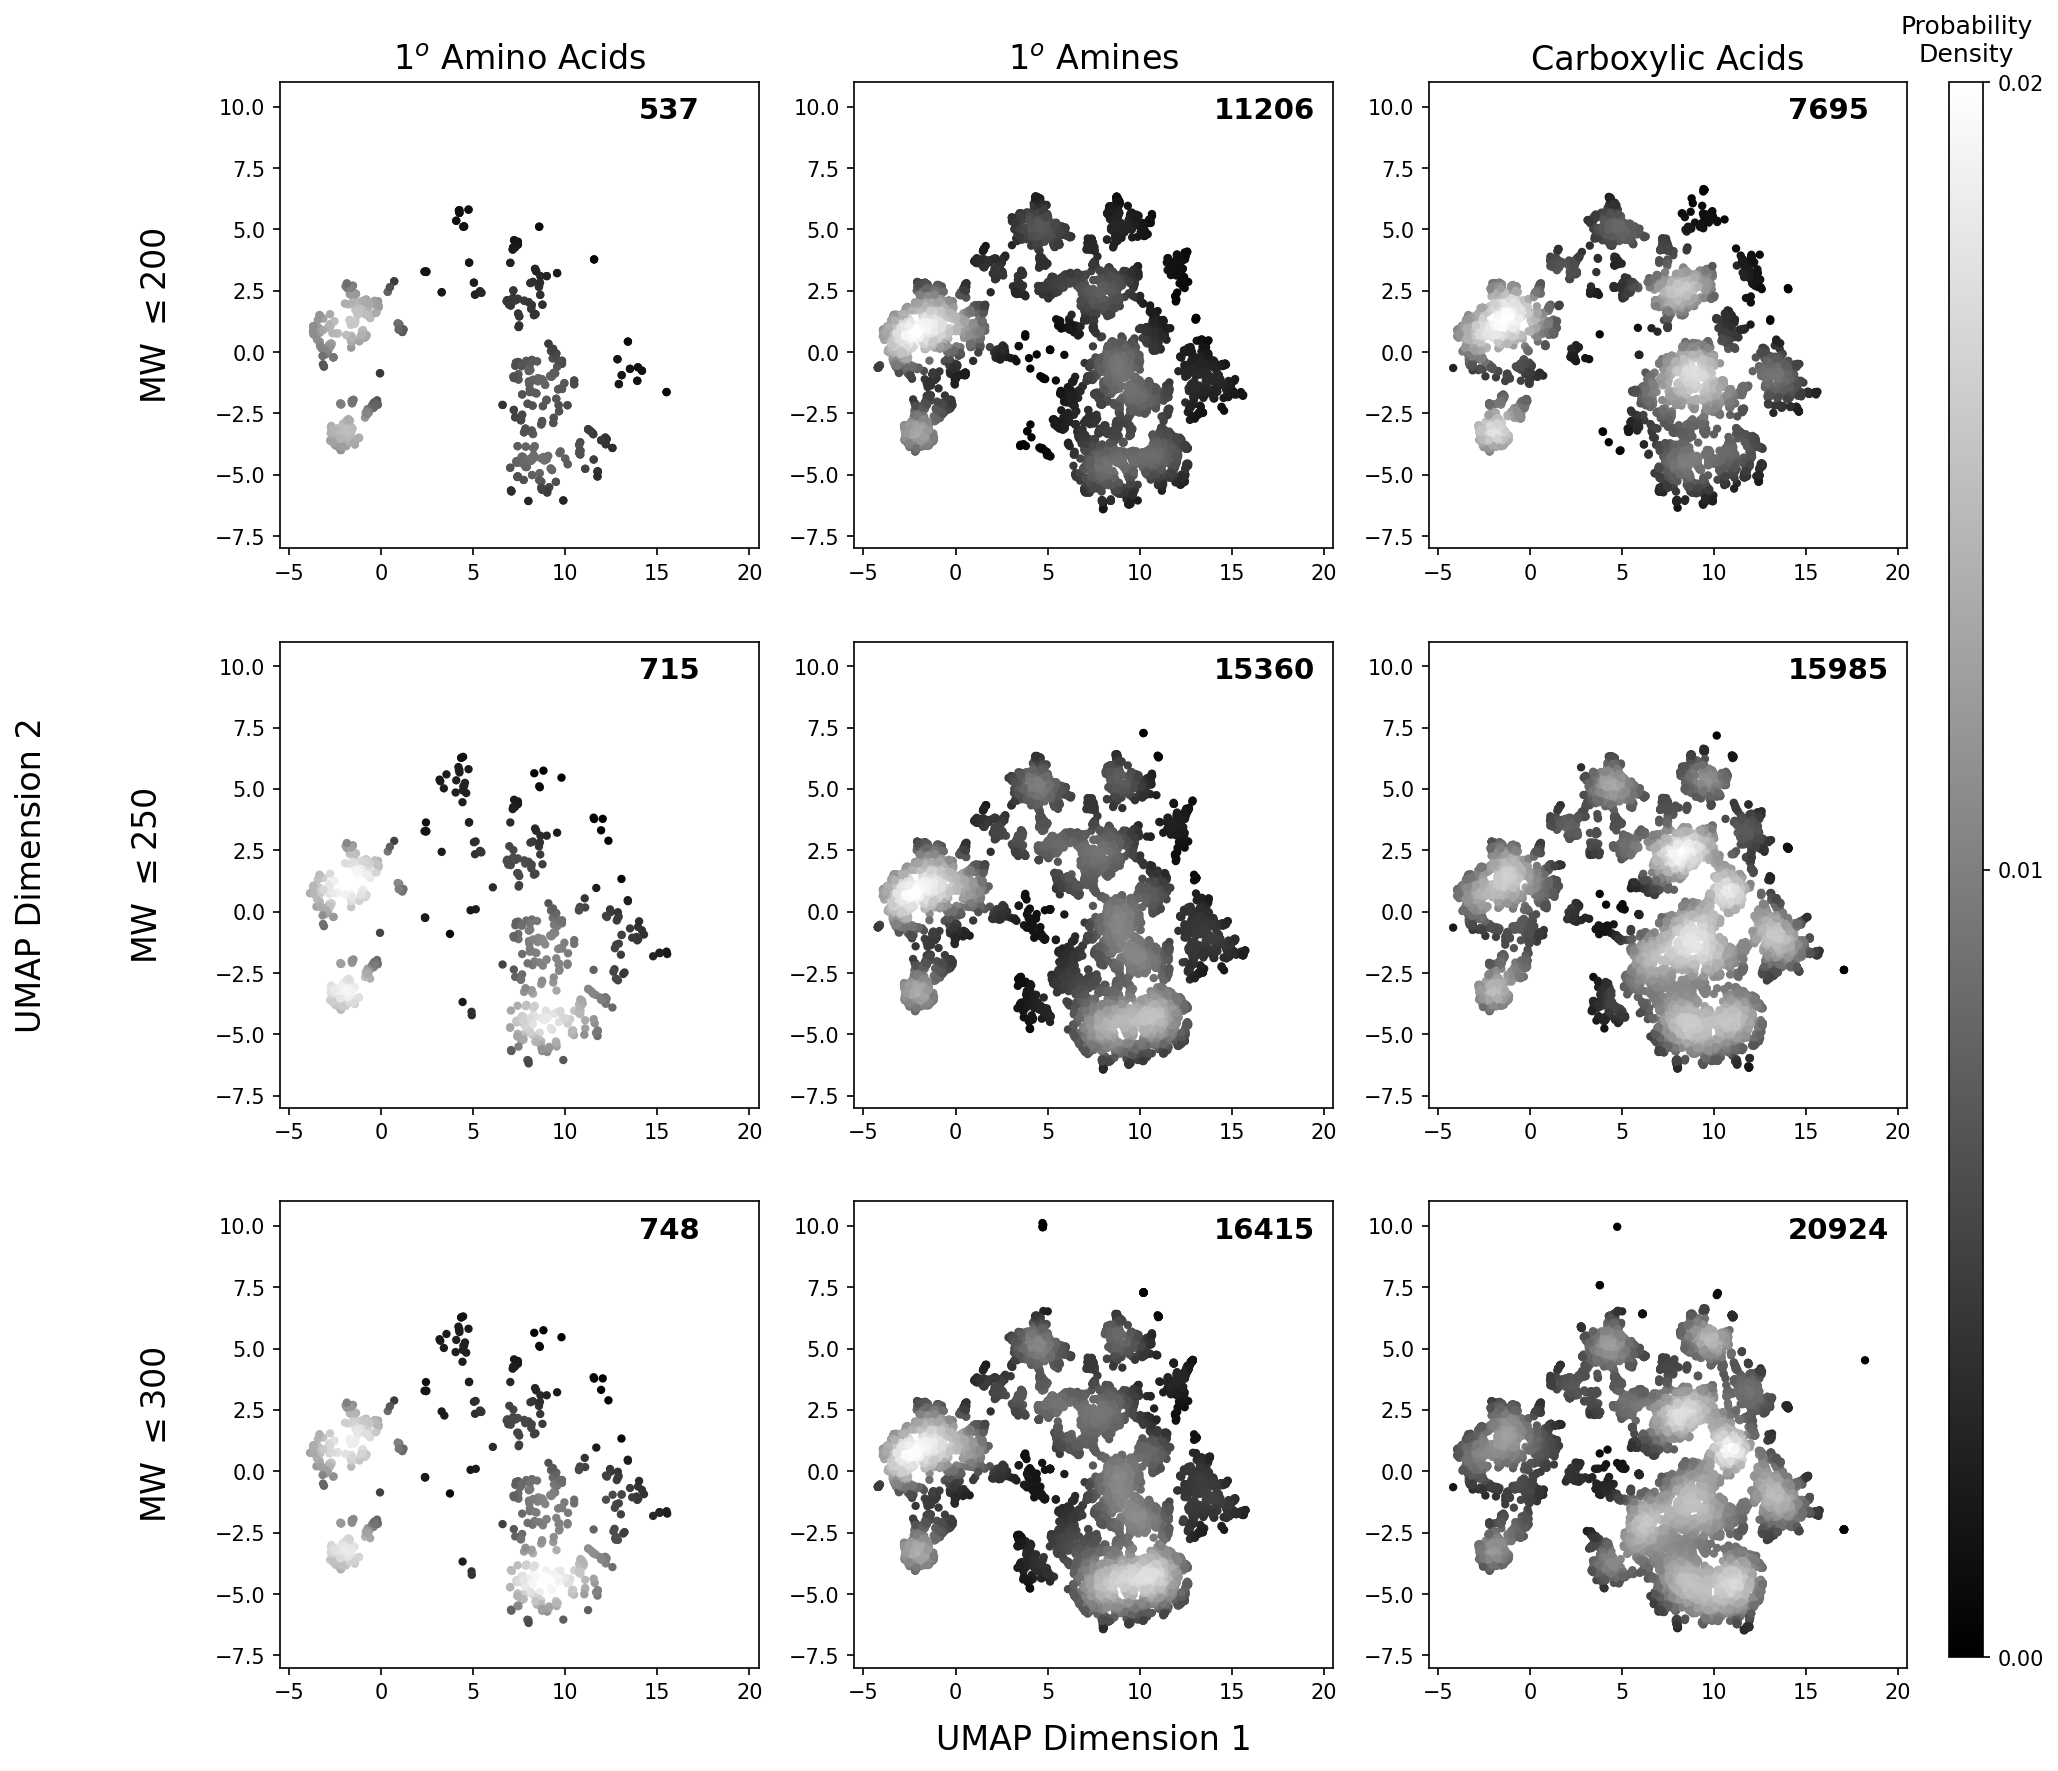

In [39]:
fig, axs = plt.subplots(3, 3, figsize=(14,14), dpi=150)
mw_list = [pAA_mw200, pamine_mw200, cooh_mw200,
           pAA_mw250, pamine_mw250, cooh_mw250,
           pAA_mw300, pamine_mw300, cooh_mw300]

z_list = [z_pAA_mw200, z_pamine_mw200, z_cooh_mw200,
          z_pAA_mw250, z_pamine_mw250, z_cooh_mw250,
          z_pAA_mw300, z_pamine_mw300, z_cooh_mw300]

for index, ax in enumerate(axs.reshape(-1)):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(mw_list[index]['X'], mw_list[index]['Y'], c=z_list[index],
               cmap='gray', marker='.')
    ax.text(14, 9.5, f"{len(set(mw_list[index]['truncate_SMILES']))}", fontsize=14, fontweight='bold')
    
sc0 = axs[0][0].scatter(pAA_mw200['X'], pAA_mw200['Y'], c=z_pAA_mw200, cmap='gray', marker='.',
                       vmin=z_mw_min, vmax=z_mw_max)

axs[0][0].set_title('$1^{o}$ Amino Acids', fontsize=16)
axs[0][1].set_title('$1^{o}$ Amines', fontsize=16)
axs[0][2].set_title('Carboxylic Acids', fontsize=16)

axs[0][0].set_ylabel('MW $\leq 200$', rotation=90, labelpad=20, fontsize=16)
axs[1][0].set_ylabel('UMAP Dimension 2', labelpad=80, fontsize=16)
axs[1][1].set_ylabel('MW $\leq 250$', rotation=90, labelpad=300, fontsize=16)

axs[2][0].set_ylabel('MW $\leq 300$', rotation=90, labelpad=20, fontsize=16)
axs[2][1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16)

n_ticks = 3
cbar_ax1 = fig.add_axes([0.92, 0.13, 0.016, 0.75])
cbar_ax1.set_title('Probability\nDensity', pad=10)
cbar = plt.colorbar(sc0, cax=cbar_ax1)
cbar.set_ticks(np.linspace(z_mw_min, z_mw_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(z_mw_min, z_mw_max, n_ticks)])

#fig.savefig('../../figures/figure_4.png')
#fig.savefig('../../figures/figure_4.svg')
plt.show()

### Figure 5: Selection strategies

In [48]:
pamine_rand = random_selection(pamine_umap, N=192, seed=0)
cooh_rand = random_selection(cooh_umap, N=192, seed=0)

In [49]:
pamine_div = diversity_selection(pamine_umap, N=192, seed=1)
cooh_div = diversity_selection(cooh_umap, N=192, seed=1)

In [50]:
pamine_unif = uniform_selection(pamine_umap, N=192, seed=2)
cooh_unif = uniform_selection(cooh_umap, N=192, seed=2)

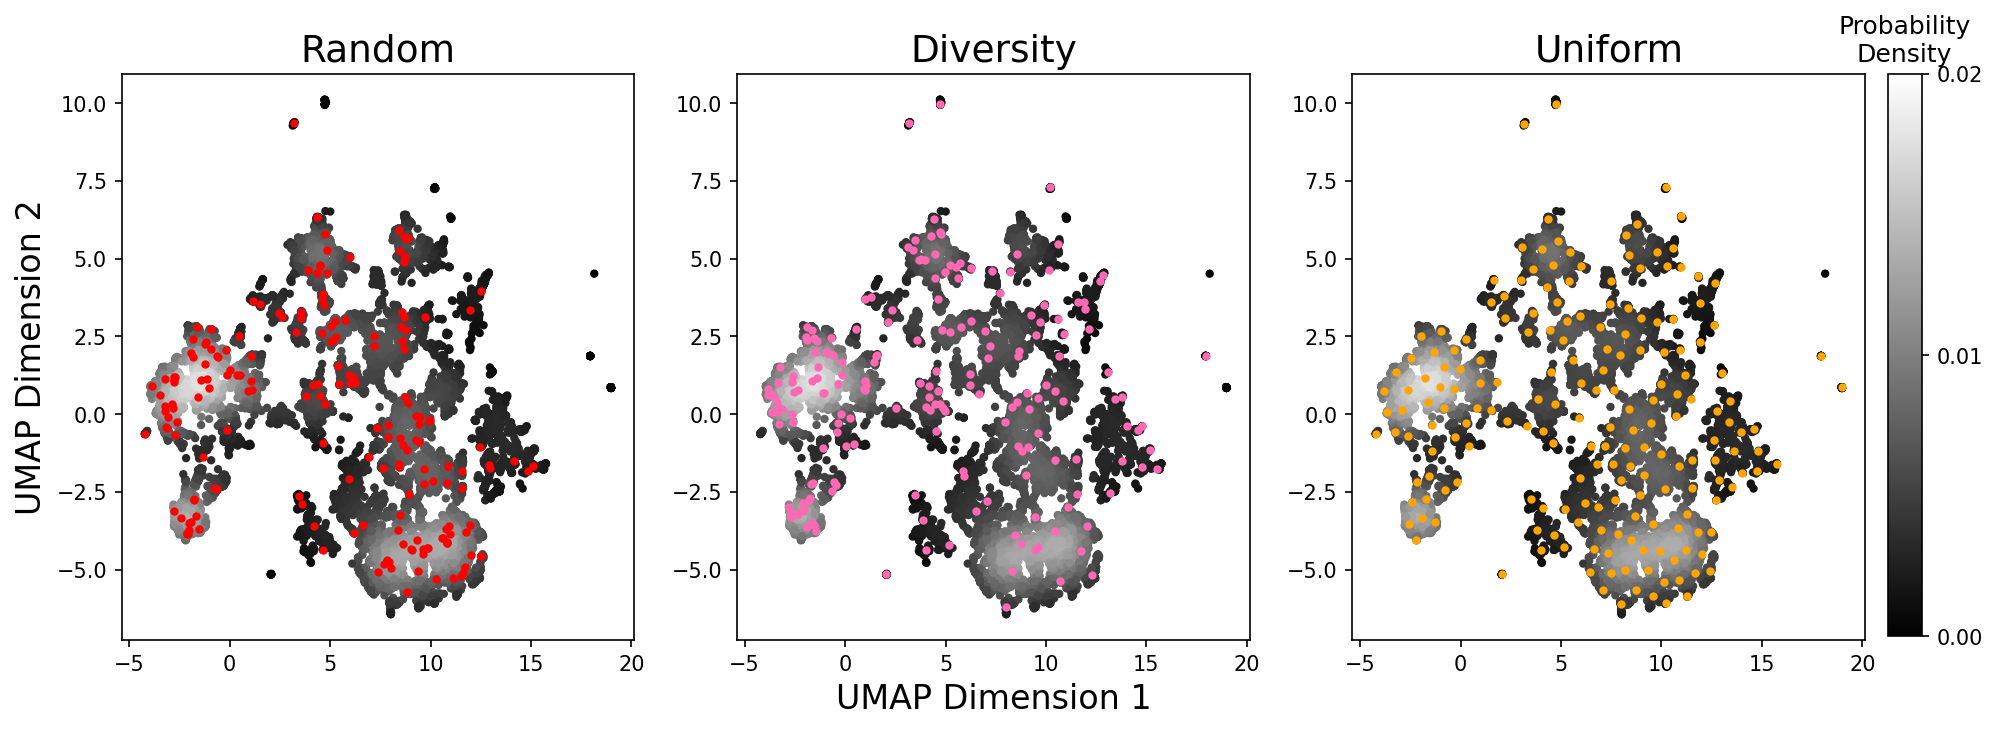

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=150)
sc = axs[0].scatter(pamine_umap['X'], pamine_umap['Y'], marker='.', c=z_pamine, cmap='gray',
              vmin=t_min, vmax=t_max)
axs[0].scatter(pamine_rand['X'], pamine_rand['Y'], marker='.', color='red', alpha=1)
axs[0].set_title('Random', fontsize=18)

axs[1].scatter(pamine_umap['X'], pamine_umap['Y'], marker='.', c=z_pamine, cmap='gray',
              vmin=t_min, vmax=t_max)
axs[1].scatter(pamine_div['X'], pamine_div['Y'], marker='.', color='hotpink')
axs[1].set_title('Diversity', fontsize=18)

axs[2].scatter(pamine_umap['X'], pamine_umap['Y'], marker='.', c=z_pamine, cmap='gray',
              vmin=t_min, vmax=t_max)
axs[2].scatter(pamine_unif['X'], pamine_unif['Y'], marker='.', color='orange')
axs[2].set_title('Uniform', fontsize=18)

cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
cbar_ax.set_title("Probability\nDensity")

n_ticks = 3
cbar = plt.colorbar(sc, cbar_ax)
cbar.set_ticks(np.linspace(t_min, t_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(t_min, t_max, n_ticks)])

axs[0].set_ylabel('UMAP Dimension 2', fontsize=16)
axs[1].set_xlabel('UMAP Dimension 1', fontsize=16)

#fig.savefig('../../figures/figure_5.png')
#fig.savefig('../../figures/figure_5.svg')

plt.show()

### Sample library enumeration

In this work we consider three design considerations:
1. cost filter
2. mw filter
3. selection strategy

We provide an example of three libraries with BBs selected with MW $\leq$ 250 filter, random selection strategy and differing cost filter.

For additional examples, refer to `'../library_enum/custom_library_enumeration.ipynb'`

#### Library 1: cost $\leq$ 100, MW $\leq$ 250, random selection (192 x 192)

In [52]:
lib1_cost = [100, 100]
lib1_mw = [250, 250]
lib1_nBBs = [192, 192]

lib1_p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= lib1_cost[0]) & (pamine_umap['MW'] <= lib1_mw[0])]
lib1_p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= lib1_cost[1]) & (cooh_umap['MW'] <= lib1_mw[1])]

lib1_p1_BBs = random_selection(lib1_p1_sele, lib1_nBBs[0], seed=0)
lib1_p2_BBs = random_selection(lib1_p2_sele, lib1_nBBs[1], seed=0)

library_1 = lib_enum(lib1_p1_BBs, lib1_p2_BBs)

#### Library 2: cost $\leq$ 250, MW $\leq$ 250, random selection (192 x 192)

In [53]:
lib2_cost = [250, 250]
lib2_mw = [250, 250]
lib2_nBBs = [192, 192]

lib2_p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= lib2_cost[0]) & (pamine_umap['MW'] <= lib2_mw[0])]
lib2_p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= lib2_cost[1]) & (cooh_umap['MW'] <= lib2_mw[1])]

lib2_p1_BBs = random_selection(lib2_p1_sele, lib2_nBBs[0], seed=0)
lib2_p2_BBs = random_selection(lib2_p2_sele, lib2_nBBs[1], seed=0)

library_2 = lib_enum(lib2_p1_BBs, lib2_p2_BBs)

#### Library 3: cost $\leq$ 500, MW $\leq$ 250, random selection (192 x 192)

In [54]:
lib3_cost = [500, 500]
lib3_mw = [250, 250]
lib3_nBBs = [192, 192]

lib3_p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= lib3_cost[0]) & (pamine_umap['MW'] <= lib3_mw[0])]
lib3_p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= lib3_cost[1]) & (cooh_umap['MW'] <= lib3_mw[1])]

lib3_p1_BBs = random_selection(lib3_p1_sele, lib3_nBBs[0], seed=0)
lib3_p2_BBs = random_selection(lib3_p2_sele, lib3_nBBs[1], seed=0)

library_3 = lib_enum(lib3_p1_BBs, lib3_p2_BBs)

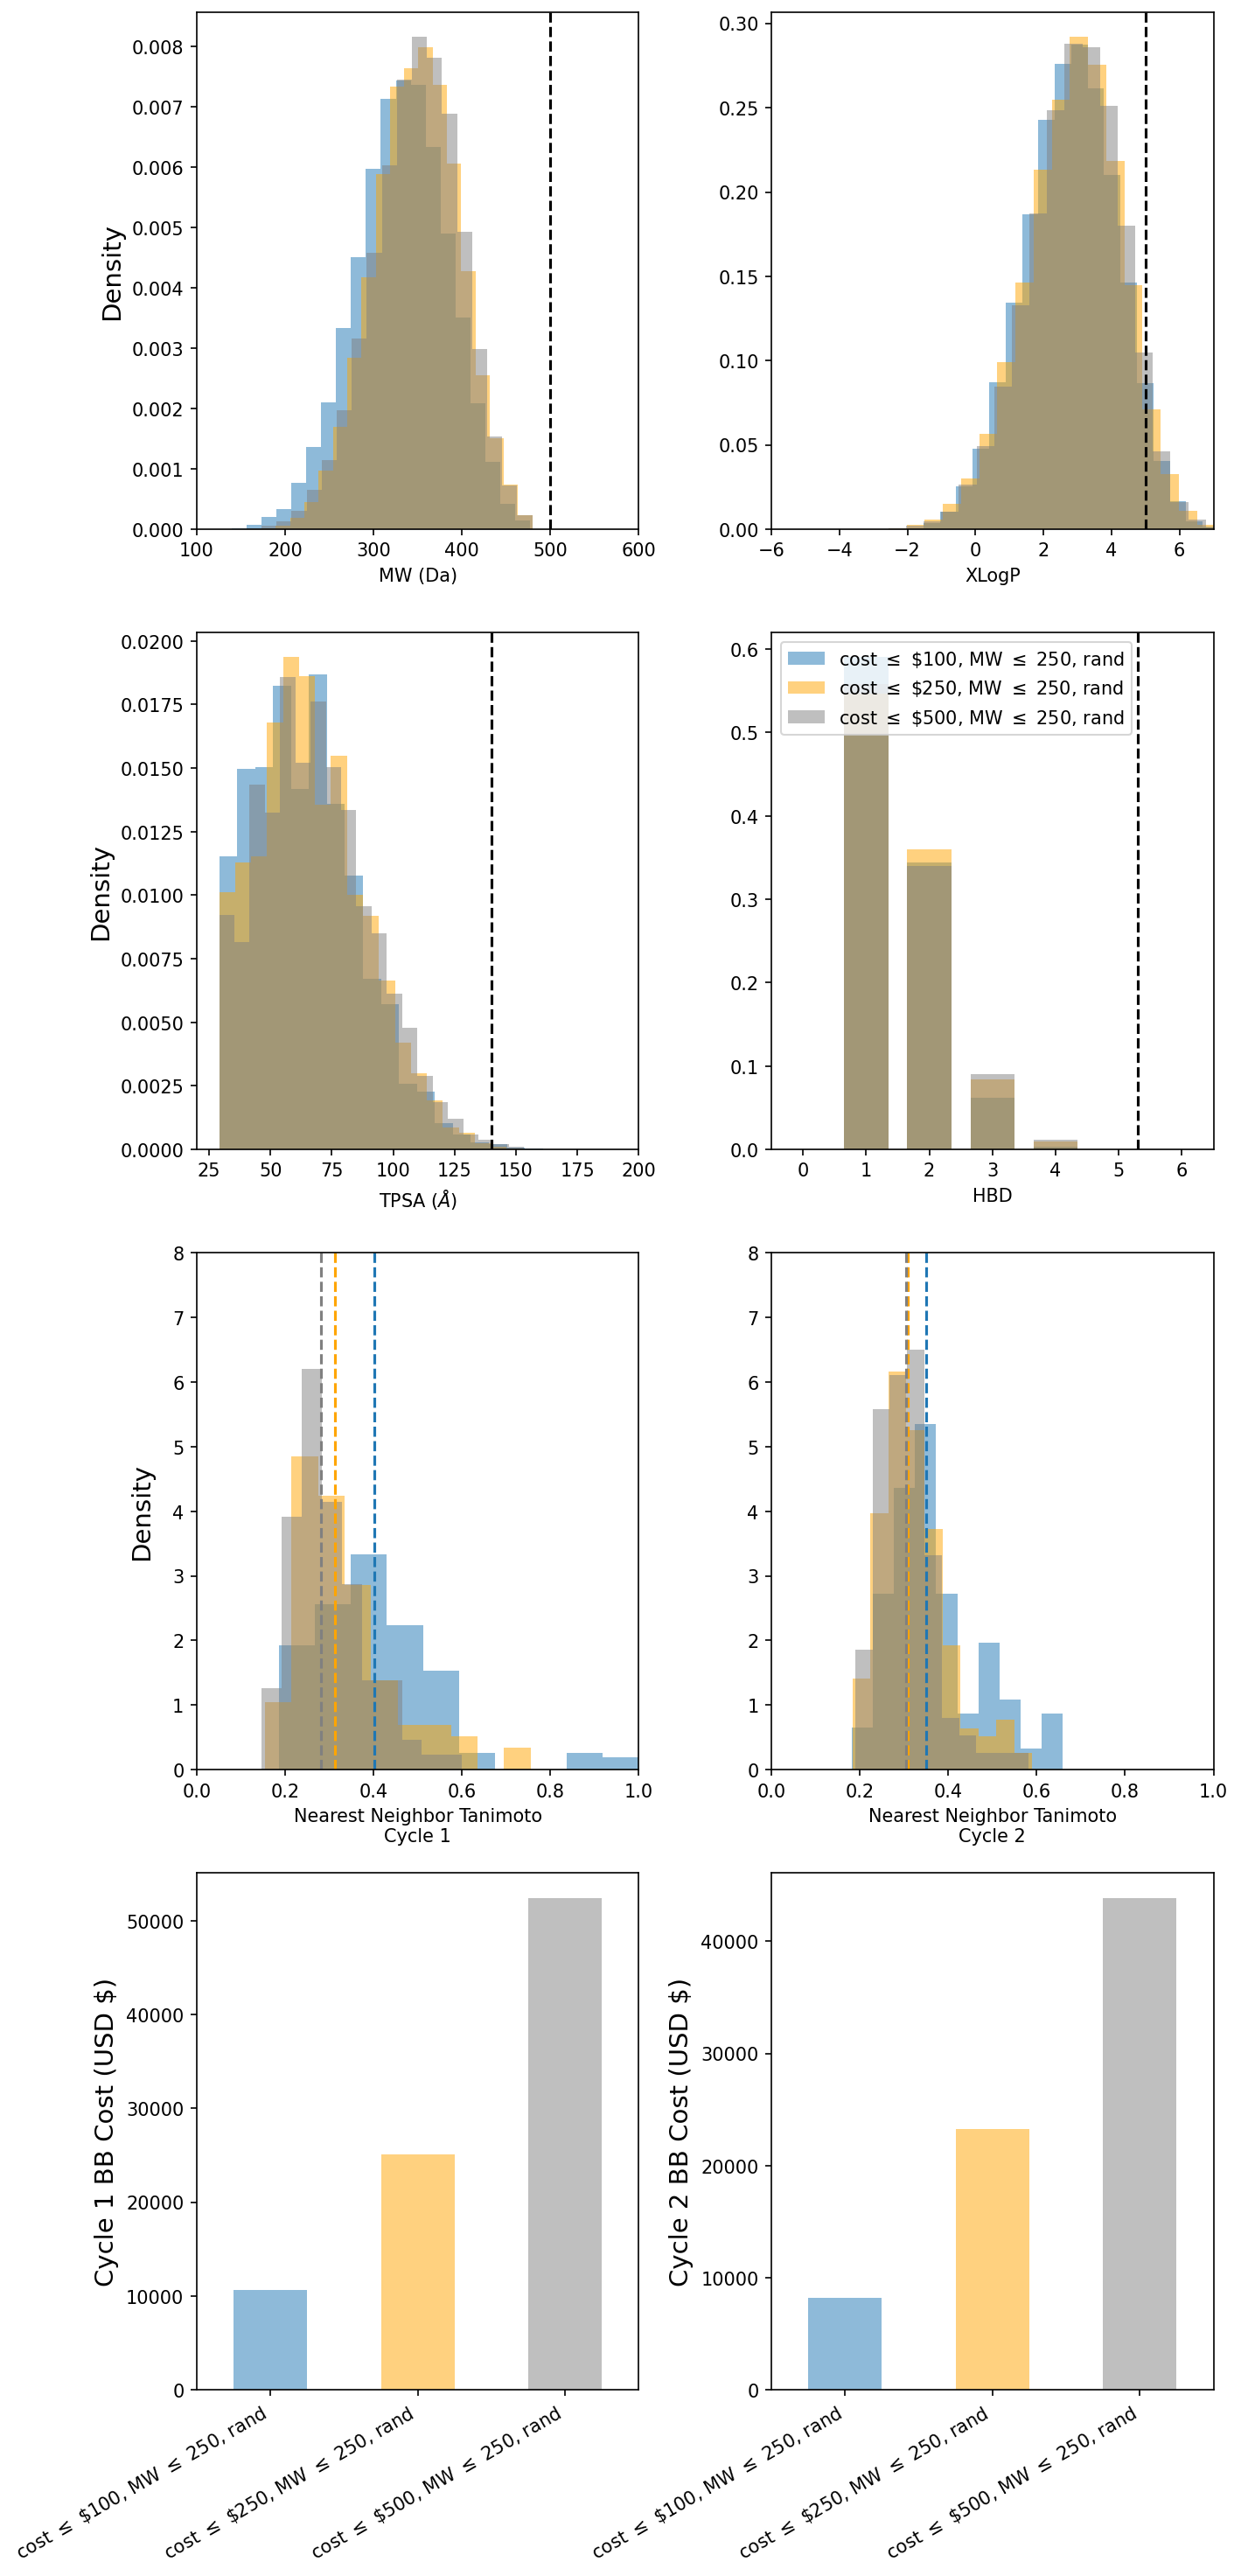

In [55]:
cost_fig = plot_library_stats(lib1_p1_BBs, lib1_p2_BBs, library_1, 'cost $\leq$ \$100, MW $\leq$ 250, rand',
                              lib2_p1_BBs, lib2_p2_BBs, library_2, 'cost $\leq$ \$250, MW $\leq$ 250, rand',
                              lib3_p1_BBs, lib3_p2_BBs, library_3, 'cost $\leq$ \$500, MW $\leq$ 250, rand')

In [56]:
#cost_fig.savefig('../../figures/figure_6.png')
#cost_fig.savefig('../../figures/figure_6.svg')